In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 13.3 MB/s 


In [2]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot,abline_plot
import shap
warnings.filterwarnings("ignore")

Importando la data

In [3]:
data = pd.read_csv("/content/data (9).csv",index_col=0)

Encoding Binario para la data categórica

In [4]:
from sklearn.preprocessing import LabelEncoder
data["CULTIVO"] = LabelEncoder().fit_transform(data["CULTIVO"])

In [5]:
data = data[["LATITUD","LONGITUD","ASNM","CULTIVO","DIRECCION_VIENTO","HUMEDAD","PRECIPITACION","PRESION_ATMOSFERICA","TEMPERATURA","TEMPERATURA_MAXIMA","TEMPERATURA_MINIMA","VELOCIDAD_VIENTO","AREA SEMBRADA (HA)","AREA COSECHADA (HA)","PRODUCCION (T)","RENDIMIENTO CALCULADO (T/HA)"]]

Descripción del dataset

In [7]:
#Dimensión del dataset
print("Shape del dataset",np.shape(data))

Shape del dataset (1497, 16)


In [9]:
#Resumen de estadísticas del dataset
data.describe()

,LATITUD,LONGITUD,ASNM,CULTIVO,DIRECCION_VIENTO,HUMEDAD,PRECIPITACION,PRESION_ATMOSFERICA,TEMPERATURA,TEMPERATURA_MAXIMA,TEMPERATURA_MINIMA,VELOCIDAD_VIENTO,AREA SEMBRADA (HA),AREA COSECHADA (HA),PRODUCCION (T),RENDIMIENTO CALCULADO (T/HA)
count,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1.497000e+03,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000
mean,5.416306,-74.739704,949.724783,0.498998,148.338538,76.642832,6.073069e+03,885.199304,21.708390,33.931109,11.740027,1.873254,1424.373293,1193.981810,1066.379372,0.783858
std,2.679134,1.705958,749.192053,0.500166,64.719147,15.507463,7.786547e+04,95.985227,5.206357,6.561470,8.829165,1.932648,2656.157079,2292.668084,2055.649207,0.348149
min,-4.210000,-78.750000,2.000000,0.000000,1.200000,0.038133,1.000000e-01,590.478369,0.818269,12.400000,-15.000000,0.117530,1.000000,1.000000,0.500000,0.064639
25%,3.900000,-75.880000,223.000000,0.000000,131.989482,73.635001,6.353000e+02,821.737922,18.799242,29.900000,8.900000,1.140749,83.000000,58.000000,33.000000,0.500000
50%,5.120000,-75.150000,955.000000,0.000000,169.755220,79.905402,1.445600e+03,888.763311,22.189488,34.700000,13.700000,1.541667,365.000000,300.000000,193.000000,0.700000
75%,7.120000,-73.350000,1527.000000,1.000000,188.350455,85.506351,2.609600e+03,976.721893,25.954838,37.800000,17.900000,1.991130,1425.000000,1110.000000,954.000000,1.053262
max,11.530000,-67.920000,3203.000000,1.000000,260.090617,99.637873,2.523428e+06,1140.558333,37.356887,50.000000,24.100000,45.767558,18724.000000,18724.000000,18874.000000,3.174757


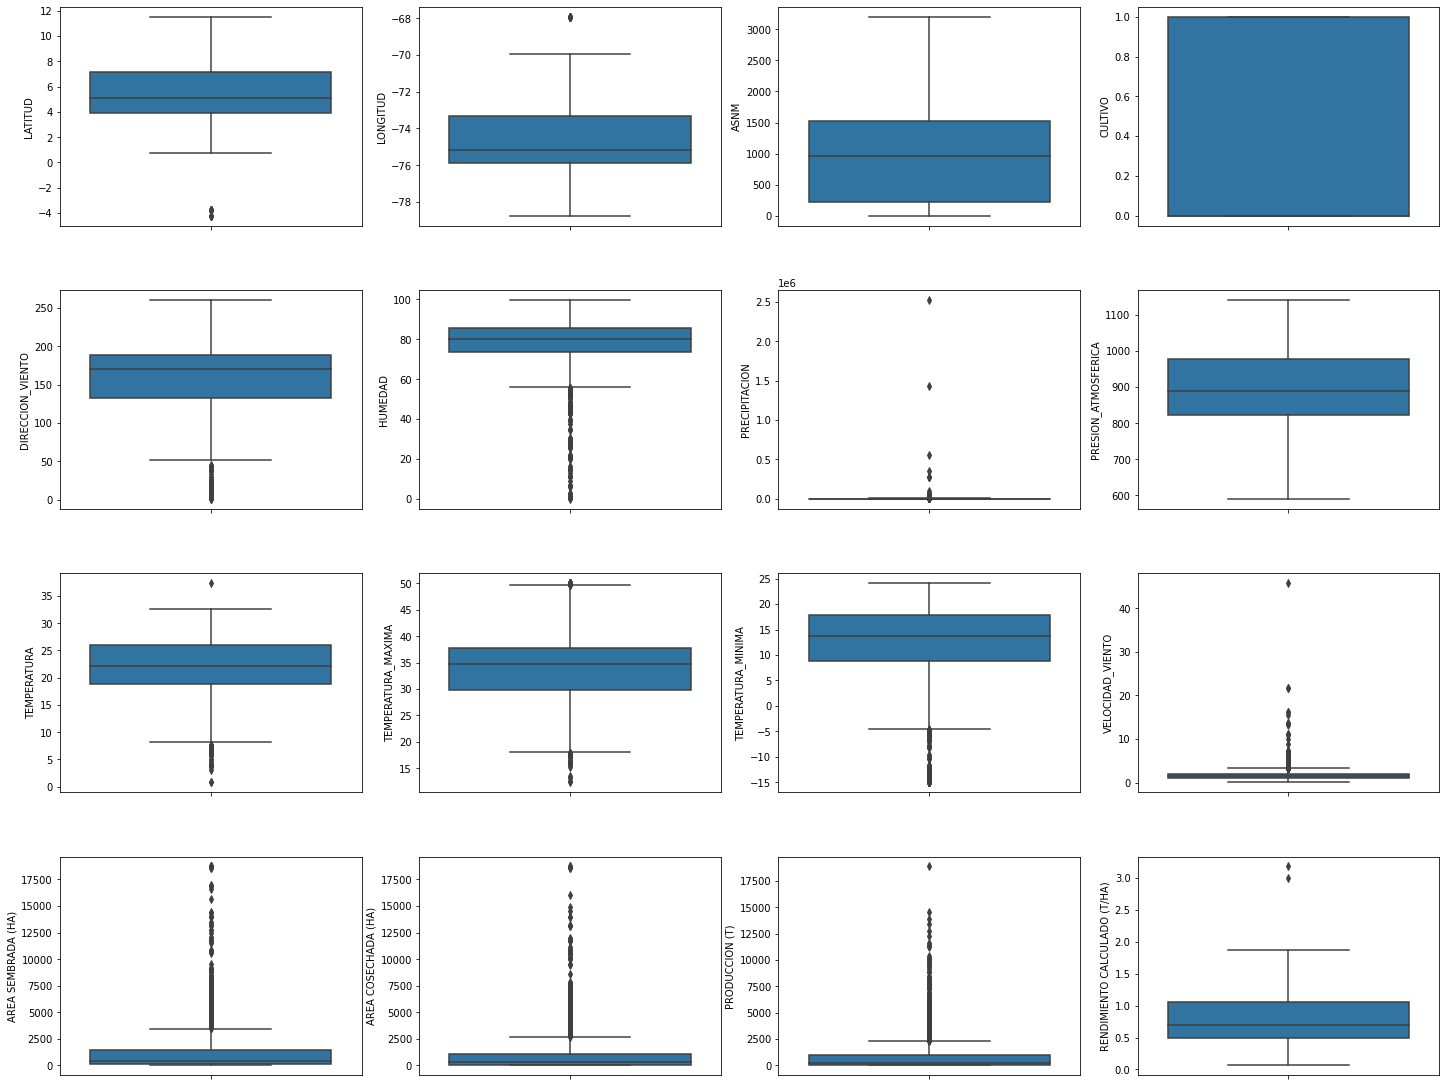

In [10]:
# BoxPlots del datatset
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20, 15))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [11]:
# Detectando Outliers utilizando el rango intercuartílico
for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Columna %s outliers = %.2f%%" % (k, perc)) 

Columna LATITUD outliers = 1.00%
Columna LONGITUD outliers = 0.80%
Columna ASNM outliers = 0.00%
Columna CULTIVO outliers = 0.00%
Columna DIRECCION_VIENTO outliers = 14.03%
Columna HUMEDAD outliers = 7.21%
Columna PRECIPITACION outliers = 9.89%
Columna PRESION_ATMOSFERICA outliers = 0.00%
Columna TEMPERATURA outliers = 2.20%
Columna TEMPERATURA_MAXIMA outliers = 3.61%
Columna TEMPERATURA_MINIMA outliers = 6.88%
Columna VELOCIDAD_VIENTO outliers = 8.75%
Columna AREA SEMBRADA (HA) outliers = 13.03%
Columna AREA COSECHADA (HA) outliers = 13.43%
Columna PRODUCCION (T) outliers = 14.83%
Columna RENDIMIENTO CALCULADO (T/HA) outliers = 0.13%


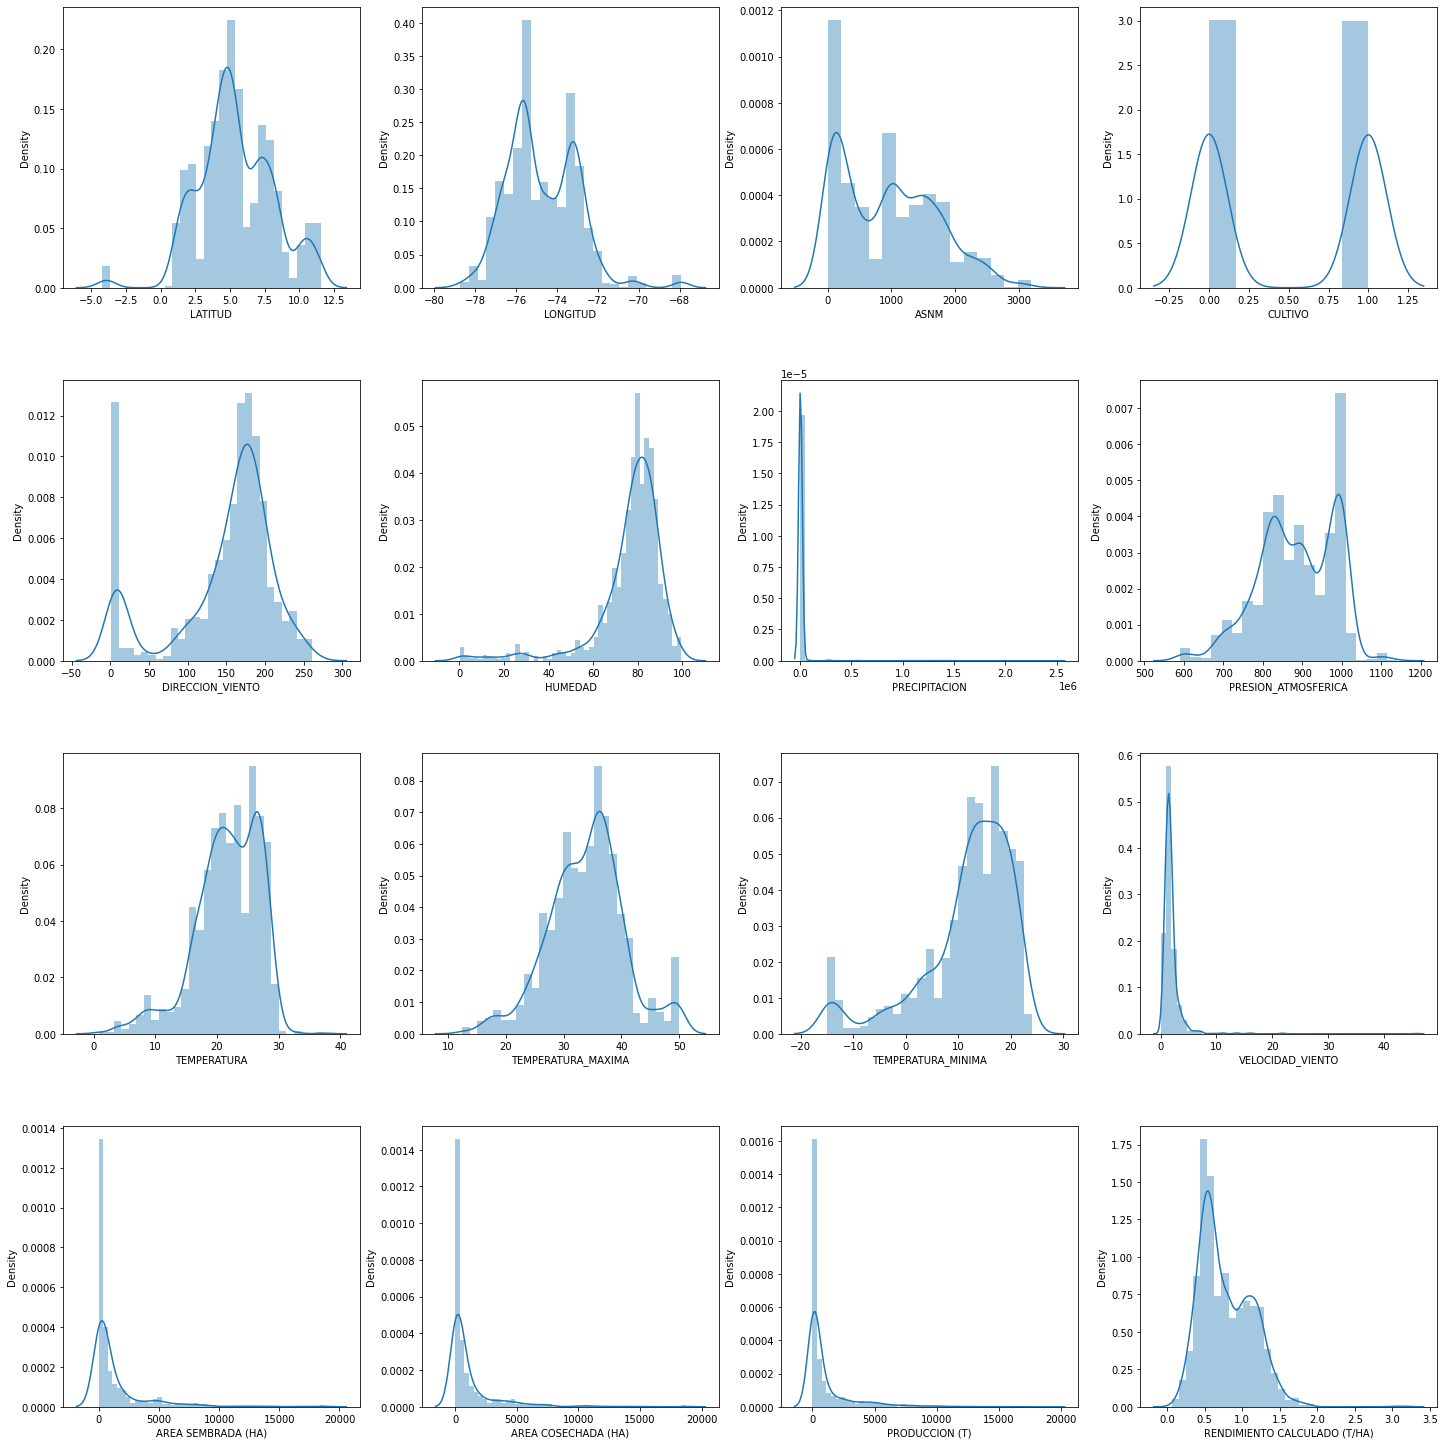

In [12]:
# Graficando las distribuciones de probabilidad del datatset
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Los gráficos de histogramas muestran que las columnas HUMEDAD, PRECIPITACION, VELOCIDAD VIENTO tienen distribuciones altamente sesgadas. Las variables AREA COSECHADA (HA) Y PRODUCCION (T) siguen la misma distribución de probabilidad que la variable AREA SEMBRADA lo cual sugiere a priori una alta correlación entre las variables. El RENDIMIENTO (T/HA) parece seguir una distribución normal; otras columnas parecen seguir una distribución normal o multimodal excepto CULTIVO, la cual es una variables binaria.

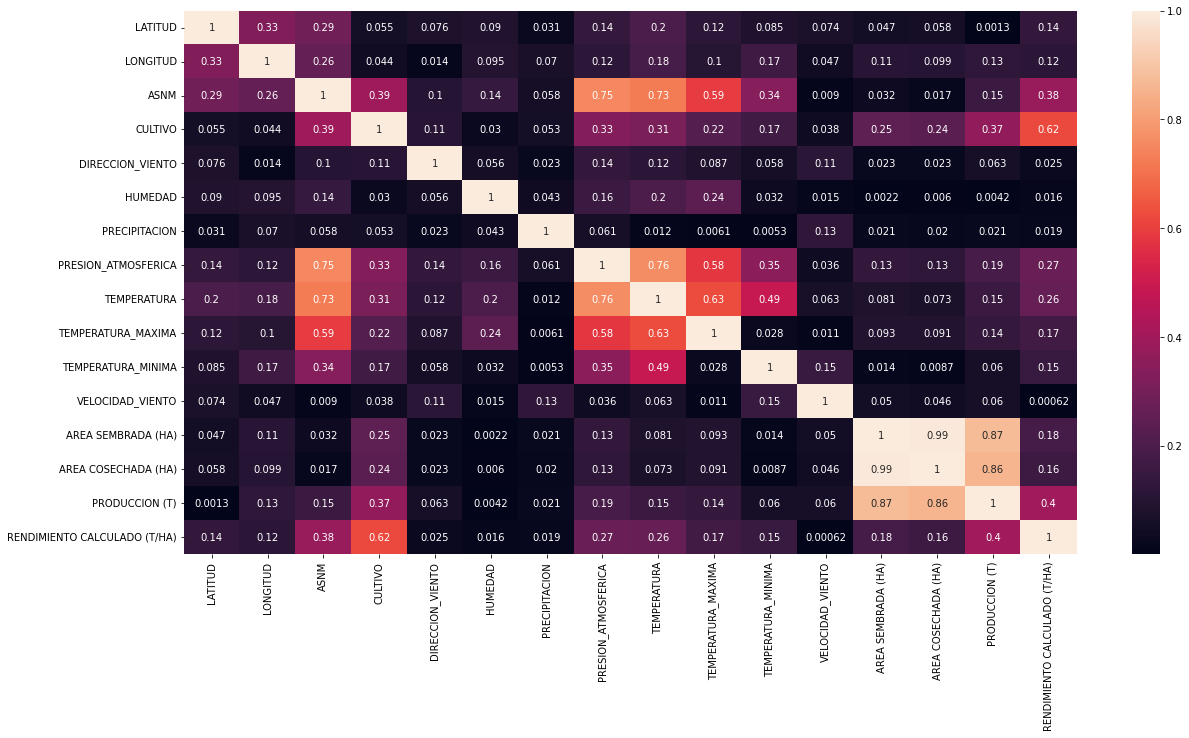

In [13]:
# Correlación por pares de datos de la totalidad del dataset
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),annot=True)

**Implementación de modelos**

***División del conjunto de datos en Entrenamiento, Validación y Prueba***

In [14]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
# Definiendo el dataset de entrada para los modelos
data = data[["LATITUD","LONGITUD","ASNM","CULTIVO","DIRECCION_VIENTO","HUMEDAD","PRECIPITACION","PRESION_ATMOSFERICA","TEMPERATURA","TEMPERATURA_MAXIMA","TEMPERATURA_MINIMA","VELOCIDAD_VIENTO","AREA SEMBRADA (HA)","RENDIMIENTO CALCULADO (T/HA)"]]
columns = data.drop("RENDIMIENTO CALCULADO (T/HA)",axis=1)

In [18]:
# División del dataset y escalado de datos
X = data.iloc[:, 0:13].values
Y = data.iloc[:, 13].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 25) #podemos setear el random state a 0
sc_X = StandardScaler()
sc_y = StandardScaler() 
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test) 
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of Y_test",Y_test.shape)

Shape of X_train:  (1197, 13)
Shape of X_test:  (300, 13)
Shape of Y_train:  (1197, 1)
Shape of Y_test (300, 1)


***Análisis y Reducción de la Dimensionalidad del dataset seleccionado***

***Análisis de Correlaciones***

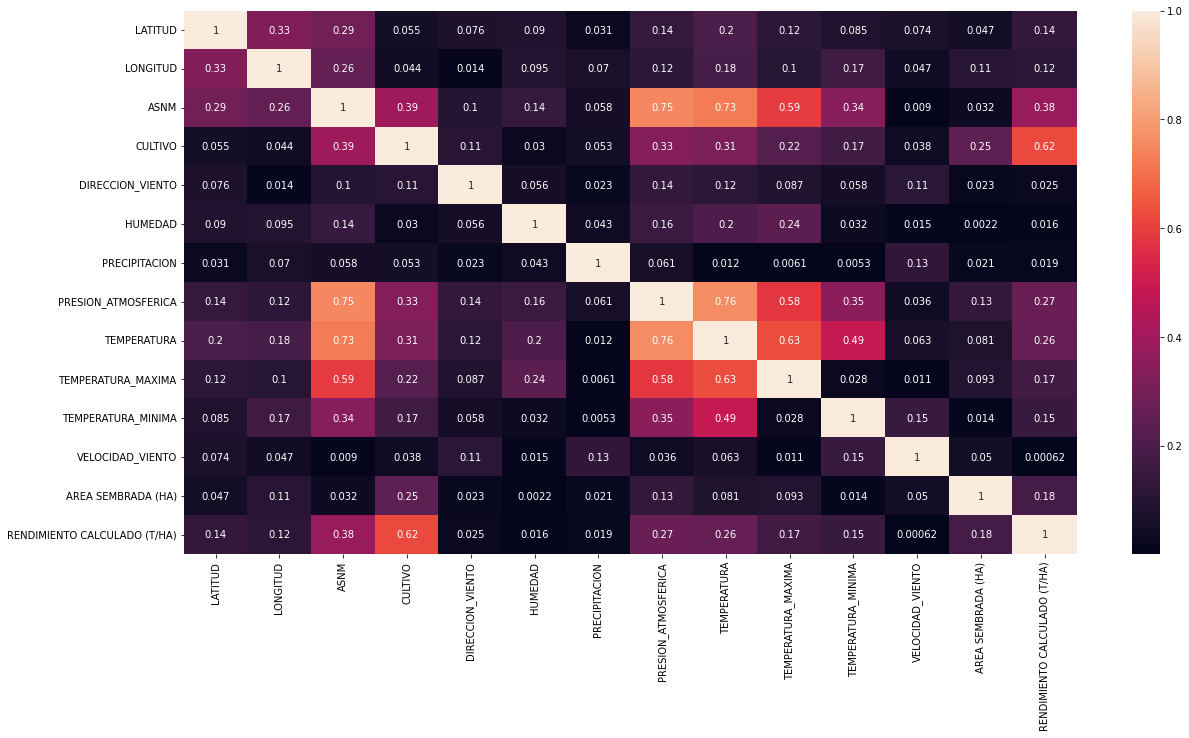

In [19]:
# Correlación por pares de datos del dataset seleccionado
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),annot=True)

***Multicolinealidad***

In [20]:
# Análisis del VIF para identificar posibles relaciones de dependencia en las variables independientes del conjunto de datos de entrenamiento
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data.iloc[:, 0:13]
vif_data = pd.DataFrame() 
vif_data["Feature"] =X.columns 
vif_data["VIF"] = [variance_inflation_factor(X_train, i) 
                          for i in range(len(X.columns))] 
print(vif_data)

                Feature       VIF
0               LATITUD  1.238143
1              LONGITUD  1.252903
2                  ASNM  3.356496
3               CULTIVO  1.288675
4      DIRECCION_VIENTO  1.049054
5               HUMEDAD  1.094764
6         PRECIPITACION  1.047001
7   PRESION_ATMOSFERICA  3.017780
8           TEMPERATURA  3.879198
9    TEMPERATURA_MAXIMA  2.181735
10   TEMPERATURA_MINIMA  1.628969
11     VELOCIDAD_VIENTO  1.075487
12   AREA SEMBRADA (HA)  1.136568


***Análisis de características significativas usando Backward Elimination***

In [21]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# Utilizando un algoritmo de Randoom Forest para encontrar la mejor combinación de variables
from sklearn.ensemble import RandomForestRegressor
sfs = SFS(RandomForestRegressor(n_jobs=-1,random_state=0), 
          k_features=(1,13), 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5,
          )
sfs = sfs.fit(X_train,Y_train)

print('\nCaracterísticas Significativas (índice en el dataframe):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)


Características Significativas (índice en el dataframe):
(0, 1, 2, 3, 4, 11, 12)
CV Score:
0.553733788791717


La técnica Backward elimination sugiere que las características significativas son la longitud, la altura sobre el nivel del mar, el tipo de cultivo, la dirección del viento, la precipitación acumulada, la temperatura media y el área sembrada.

***Análisis de características significativas usando Sequential Forward Selection***

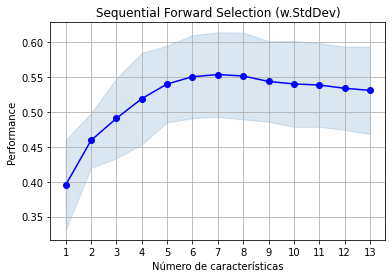

In [23]:
# Graficando el aporte de las carcaterísticas al performance del modelo, conforme se añade una a una
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.xlabel("Número de características")
plt.ylabel("Performance")
plt.title("Sequential Forward Selection (w.StdDev)")
plt.show()

Con 7 características significativas nuestro modelo alcanzaría su mejor desempeño, sin embargo, al utilizar la totalidad de características el modelo continúa presentando buen desempeño.

**Modelos de Machine Learning**

***Regresión Lineal***

In [24]:
from sklearn.linear_model import LinearRegression
regressor_linear = LinearRegression(fit_intercept=True,n_jobs=-1).fit(X_train, Y_train)

In [29]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    # Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = LinearRegression(fit_intercept=True,n_jobs=-1).fit(X_train, Y_train)

    # Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [30]:
# Guardando las 100 repeticiones en un pandas dataframe
metricslr=pd.DataFrame({'cv_lr':CV,
                        'r2_score_lr_train':R2train,
                        'r2_score_lr_test':R2test,
                        'mse_lr':MSE,
                        'rmse_lr':RMSE,
                        'mae_lr':MAE})
metricslr

,cv_lr,r2_score_lr_train,r2_score_lr_test,mse_lr,rmse_lr,mae_lr
0,0.417447,0.430137,0.411860,0.068585,0.261887,0.199973
1,0.412791,0.423133,0.430511,0.072966,0.270123,0.206438
2,0.424527,0.440225,0.365286,0.091787,0.302963,0.210271
3,0.430769,0.443159,0.362067,0.073428,0.270977,0.198735
4,0.407017,0.426085,0.421401,0.063351,0.251697,0.195341
...,...,...,...,...,...,...
95,0.428244,0.436471,0.381241,0.070540,0.265593,0.200422
96,0.418483,0.432682,0.394052,0.066576,0.258023,0.192558
97,0.402136,0.420027,0.451969,0.064528,0.254023,0.191640
98,0.406620,0.423811,0.432815,0.066334,0.257554,0.202664


In [36]:
# Exportando las 100 repeticiones
metricslr.to_csv('100 repeticiones regresion lineal.csv', encoding = 'utf-8-sig') 
files.download('100 repeticiones regresion lineal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.5297


<Figure size 432x288 with 0 Axes>

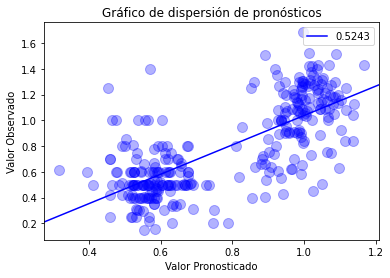

In [37]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos")
plt.legend()
plt.show()

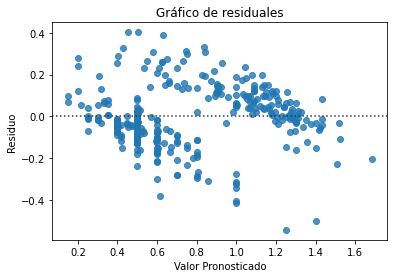

In [39]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales")
plt.show()

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

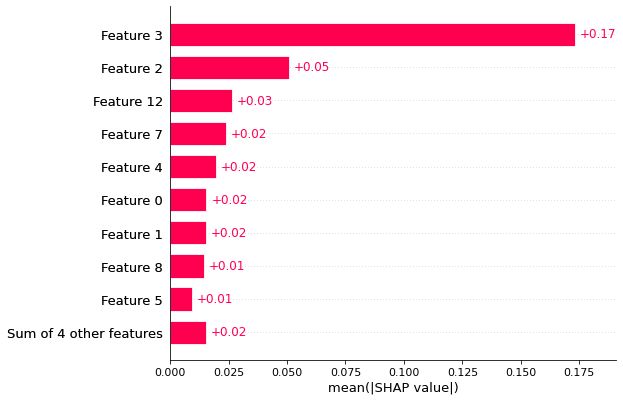

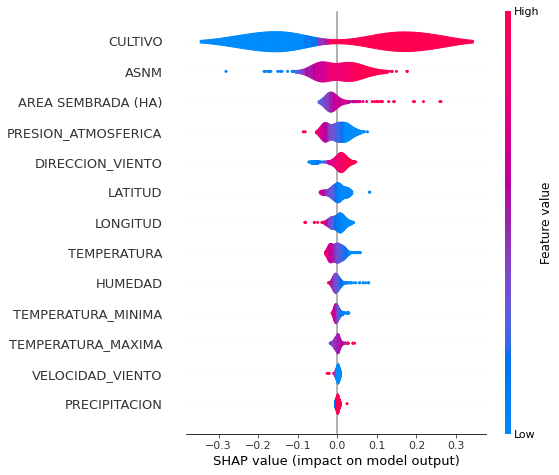

In [40]:
# Shap Values
explainer = shap.Explainer(regressor, masker=shap.maskers.Impute(data=X_Test),
                            algorithm="linear")
shap_values = explainer(X_Test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values,plot_type='violin',feature_names=columns.columns)

**Decission Tree**

In [46]:
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)

In [56]:
# Encontrando los mejores hiperparámetros para el modelo
param_grid = { 'min_samples_split':[6,8,10,12],
              'max_depth'  : [1,10,20],
              'max_features': ['auto', 'log2','sqrt'], 
              'max_leaf_nodes': [1,10,20],
              }
g_search = GridSearchCV(estimator =regressor_dt, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
g_search.fit(X_train, Y_train);
print("Los mejores parámetros son: ","\n", g_search.best_params_)

Los mejores parámetros son:  
 {'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 20, 'min_samples_split': 10}


In [108]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = DecisionTreeRegressor(criterion = "squared_error", max_depth = 10, max_features= "auto",max_leaf_nodes=20, min_samples_split=10,random_state = 0).fit(X_train, Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [109]:
# Guardando las 100 repeticiones en un pandas dataframe
metricsdt=pd.DataFrame({'cv_dt':CV,
                        'r2_score_dt_train':R2train,
                        'r2_score_dt_test':R2test,
                        'mse_dt':MSE,
                        'rmse_dt':RMSE,
                        'mae_dt':MAE})
metricsdt

,cv_dt,r2_score_dt_train,r2_score_dt_test,mse_dt,rmse_dt,mae_dt
0,0.424441,0.618987,0.375456,0.099574,0.315553,0.199718
1,0.338246,0.602603,0.420188,0.070313,0.265165,0.201371
2,0.384987,0.597010,0.522810,0.054549,0.233557,0.176086
3,0.255678,0.583097,0.454520,0.061062,0.247108,0.186914
4,0.338241,0.591877,0.397117,0.058626,0.242129,0.181686
...,...,...,...,...,...,...
95,0.350823,0.565600,0.406865,0.071149,0.266738,0.197424
96,0.304138,0.603912,0.358502,0.073206,0.270567,0.199304
97,0.400707,0.630021,0.216664,0.095289,0.308690,0.218422
98,0.445516,0.614422,-0.006215,0.110018,0.331690,0.198007


In [59]:
# Exportando las 100 repeticiones
metricslr.to_csv('100 repeticiones arbol de decision.csv', encoding = 'utf-8-sig') 
files.download('100 repeticiones arbol de decision.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.6043


<Figure size 432x288 with 0 Axes>

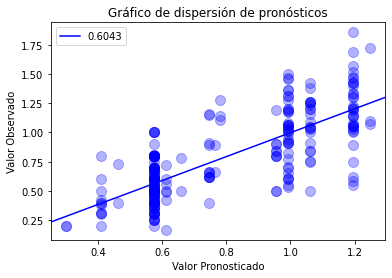

In [61]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos")
plt.legend()
plt.show()

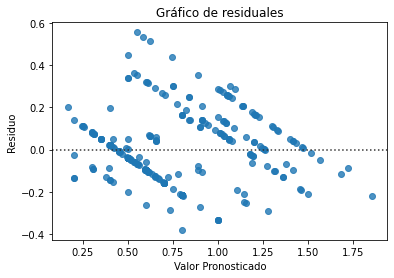

In [62]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales")
plt.show()

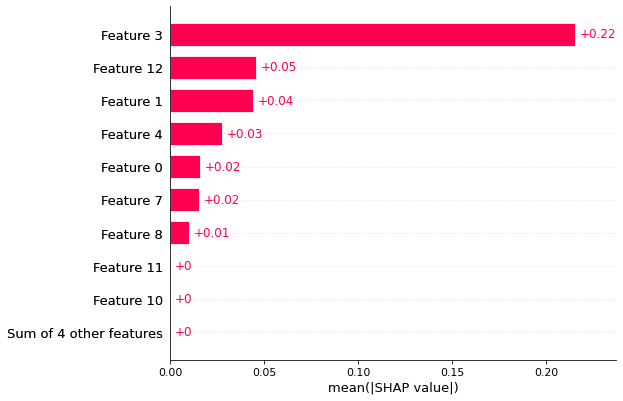

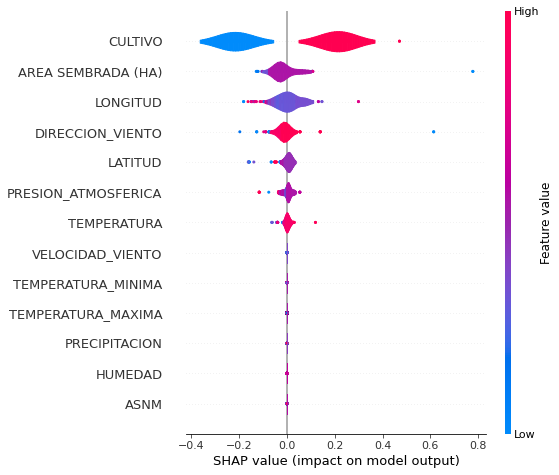

In [63]:
# Shap Values
explainer = shap.TreeExplainer(regressor, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Extreme Gradient Boosting Regressor**

In [66]:
from sklearn.ensemble import GradientBoostingRegressor
regressor_xgbr=GradientBoostingRegressor(random_state=0)

In [65]:
# Encontrando los mejores hiperparámetros para el modelo
param_grid = {'min_samples_split':[2,4,6,8,10],
              'max_depth'  : [1,10,100,1000,10000],
              'max_features': ['auto', 'log2','sqrt'], 
              'max_leaf_nodes': [1,10,100,1000,10000],
              'n_estimators': [20,50,100,150],
              }
g_search = GridSearchCV(estimator =regressor_xgbr, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
g_search.fit(X_train, Y_train);
print("Los mejores parámetros son: ","\n", g_search.best_params_)

Los mejores parámetros son:  
 {'max_depth': 10000, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_samples_split': 4, 'n_estimators': 50}


In [67]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = GradientBoostingRegressor(n_estimators = 50, min_samples_split= 4, max_depth = 1000, max_features= 'log2', max_leaf_nodes = 100, random_state = 0).fit(X_train , Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [68]:
# Guardando las 100 repeticiones en un pandas dataframe
metricsxgbr=pd.DataFrame({'cv_xgbr':CV,
                        'r2_score_xgbr_train':R2train,
                        'r2_score_xgbr_test':R2test,
                        'mse_xgbr':MSE,
                        'rmse_xgbr':RMSE,
                        'mae_xgbr':MAE})
metricsxgbr

,cv_xgbr,r2_score_xgbr_train,r2_score_xgbr_test,mse_xgbr,rmse_xgbr,mae_xgbr
0,0.508039,0.984980,0.530415,0.051013,0.225860,0.170356
1,0.517234,0.984466,0.511899,0.064909,0.254773,0.177293
2,0.551371,0.985538,0.363930,0.075267,0.274349,0.184626
3,0.502045,0.983963,0.521955,0.059153,0.243214,0.186136
4,0.529282,0.985159,0.431412,0.066929,0.258707,0.174328
...,...,...,...,...,...,...
95,0.504018,0.985357,0.351629,0.070116,0.264793,0.200223
96,0.496701,0.984880,0.471007,0.055010,0.234541,0.176733
97,0.544489,0.985640,0.454997,0.065217,0.255377,0.184503
98,0.507922,0.984629,0.498230,0.060991,0.246963,0.176088


In [69]:
# Exportando las 100 repeticiones
metricsxgbr.to_csv('100 repeticiones XGBoost.csv', encoding = 'utf-8-sig') 
files.download('100 repeticiones XGBoost.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.5952


<Figure size 432x288 with 0 Axes>

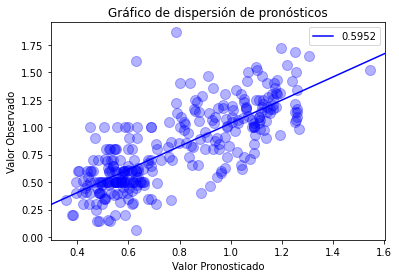

In [71]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos")
plt.legend()
plt.show()

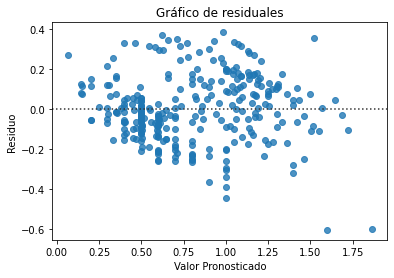

In [72]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales")
plt.show()

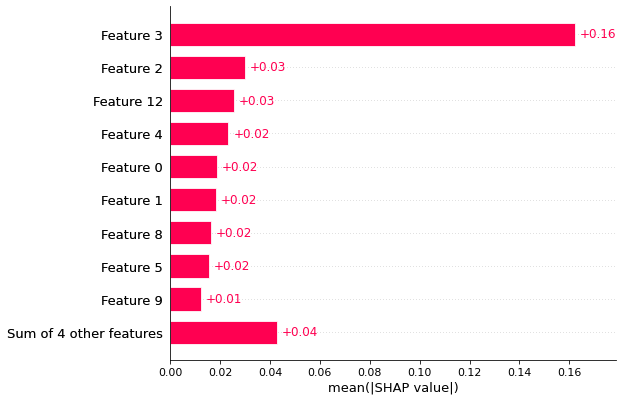

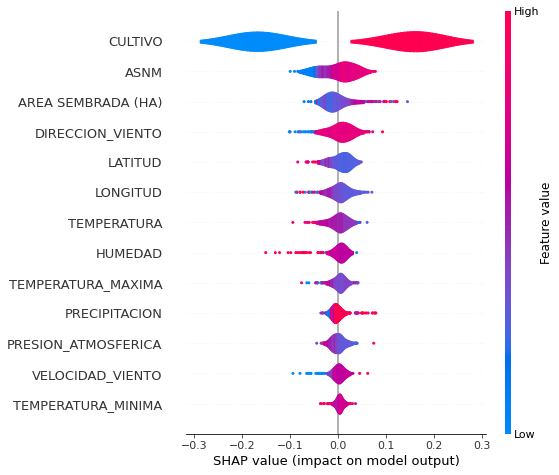

In [73]:
# Shap Values
explainer = shap.TreeExplainer(regressor, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Random Forest**

In [74]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(random_state = 0)

In [75]:
# Encontrando los mejores hiperparámetros para el modelo
param_grid = {'min_samples_split':[2,4,6,8,10],
              'max_depth'  : [1,10,100,1000,10000],
              'max_features': ['auto', 'log2','sqrt'], 
              'max_leaf_nodes': [1,10,100,1000,10000],
              'n_estimators': [300,500,800,1000],
              }
g_search = GridSearchCV(estimator =regressor_rf, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
g_search.fit(X_train, Y_train);
print("Los mejores parámetros son: ","\n", g_search.best_params_)

KeyboardInterrupt: ignored

In [87]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = RandomForestRegressor(n_estimators = 500, min_samples_split= 2, max_depth = 100, max_features= 'log2', max_leaf_nodes = 1000, random_state = 0).fit(X_train, Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [88]:
# Guardando las 100 repeticiones en un pandas dataframe
metricsrf=pd.DataFrame({'cv_rf':CV,
                        'r2_score_rf_train':R2train,
                        'r2_score_rf_test':R2test,
                        'mse_rf':MSE,
                        'rmse_rf':RMSE,
                        'mae_rf':MAE})
metricsrf

,cv_rf,r2_score_rf_train,r2_score_rf_test,mse_rf,rmse_rf,mae_rf
0,0.554272,0.944234,0.546996,0.054744,0.233975,0.176815
1,0.569456,0.942525,0.510372,0.065344,0.255625,0.177499
2,0.565266,0.939835,0.555989,0.046295,0.215162,0.161547
3,0.560729,0.941688,0.516789,0.052114,0.228284,0.172179
4,0.577266,0.942725,0.467793,0.065063,0.255075,0.172937
...,...,...,...,...,...,...
95,0.524968,0.939584,0.574699,0.054035,0.232453,0.184304
96,0.579456,0.944558,0.447672,0.060605,0.246181,0.179759
97,0.537483,0.939791,0.606564,0.042656,0.206533,0.157881
98,0.555784,0.940548,0.540905,0.050722,0.225215,0.177275


In [89]:
metricsrf.to_csv('100 repeticiones random forest.csv', encoding = 'utf-8-sig') 
files.download('100 repeticiones random forest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

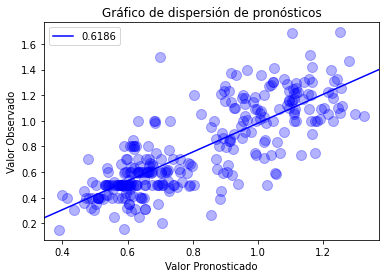

In [90]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos")
plt.legend()
plt.show()

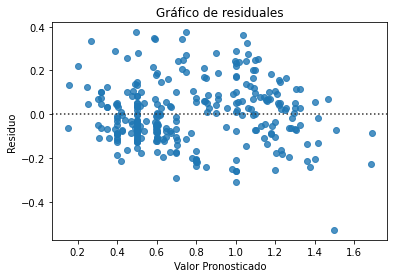

In [91]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales")
plt.show()

 99%|===================| 298/300 [01:56<00:00]       

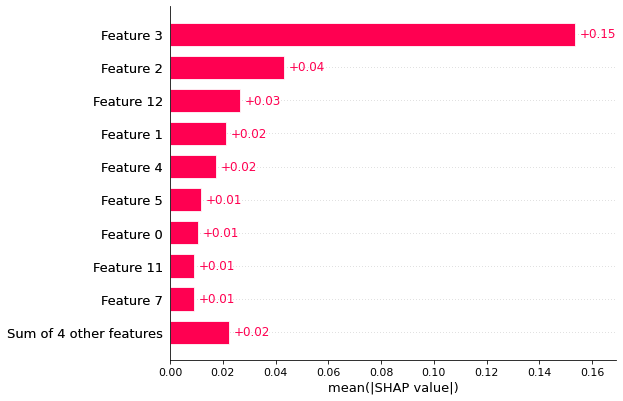

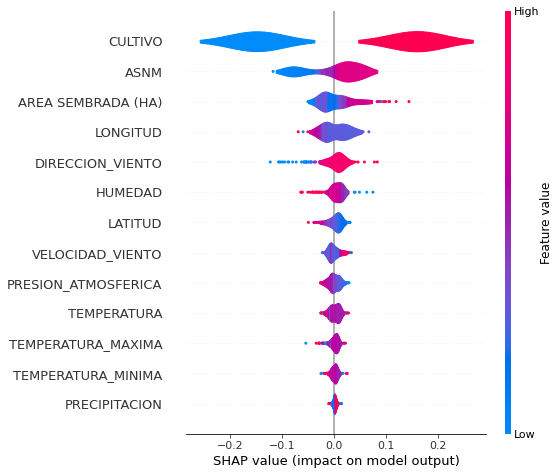

In [92]:
# Shap Values
explainer = shap.TreeExplainer(regressor, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

Support Vector Regression

In [95]:
from sklearn.svm import SVR
regressor_svr = SVR()

In [83]:
#Encontrando los mejores hiperparámetros para el modelo
param_grid = { 'kernel':['linear','rbf','sigmoid'],
              'gamma': ['scale', 'auto'], 
              'C': [0.01,0.1,1.0,10,100,1000],
              }
g_search = GridSearchCV(estimator =regressor_svr, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
g_search.fit(X_train, Y_train);
print("Los mejores parámetros son: ","\n", g_search.best_params_)

Los mejores parámetros son:  
 {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}


In [96]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = SVR(kernel="rbf", gamma ="auto", C=1).fit(X_train, Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [97]:
# Guardando las 100 repeticiones en un pandas dataframe
metricssvr=pd.DataFrame({'cv_svr':CV,
                        'r2_score_svr_train':R2train,
                        'r2_score_svr_test':R2test,
                        'mse_svr':MSE,
                        'rmse_svr':RMSE,
                        'mae_svr':MAE})
metricssvr

,cv_svr,r2_score_svr_train,r2_score_svr_test,mse_svr,rmse_svr,mae_svr
0,0.488500,0.623632,0.479048,0.055414,0.235401,0.180137
1,0.456456,0.630451,0.491480,0.066257,0.257404,0.171940
2,0.505361,0.664442,0.427172,0.086586,0.294256,0.183538
3,0.508153,0.638803,0.409064,0.061772,0.248540,0.176713
4,0.469635,0.627156,0.522418,0.056421,0.237531,0.178277
...,...,...,...,...,...,...
95,0.471911,0.638561,0.434974,0.062465,0.249931,0.184049
96,0.496705,0.631868,0.465474,0.059195,0.243300,0.175206
97,0.452777,0.619600,0.491206,0.067957,0.260686,0.177688
98,0.475334,0.623040,0.525128,0.055024,0.234572,0.174076


In [98]:
metricsrf.to_csv('100 repeticiones svr.csv', encoding = 'utf-8-sig') 
files.download('100 repeticiones svr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

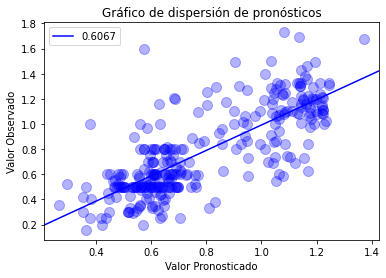

In [100]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos")
plt.legend()
plt.show()

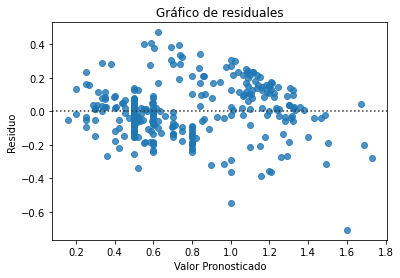

In [101]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales")
plt.show()

Permutation explainer: 301it [12:03,  2.44s/it]


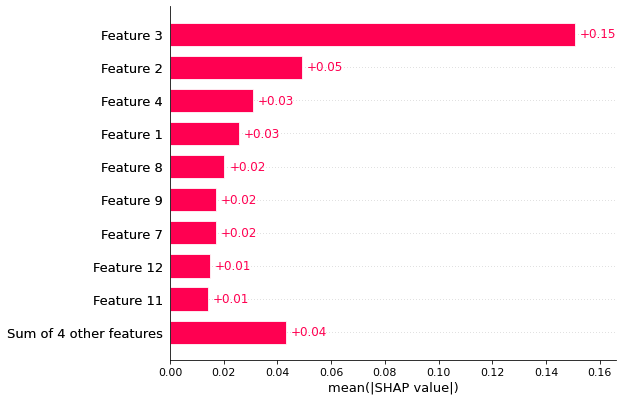

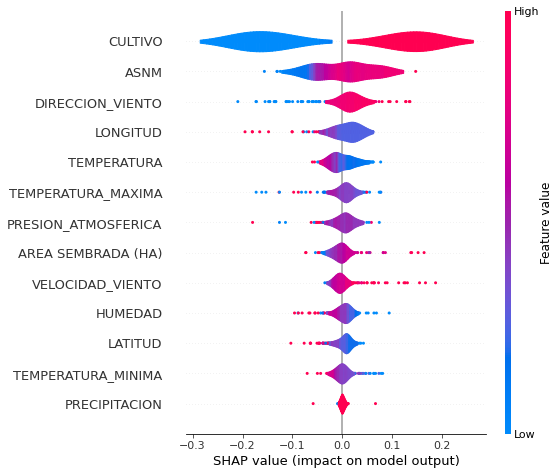

In [104]:
# Shap Values
explainer = shap.Explainer(regressor.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Deep Learning Models**

In [128]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization

***Multilayer Perceptron***

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 128)               1792      
                                                                 
 dense_121 (Dense)           (None, 64)                8256      
                                                                 
 dense_122 (Dense)           (None, 30)                1950      
                                                                 
 dense_123 (Dense)           (None, 20)                620       
                                                                 
 dense_124 (Dense)           (None, 5)                 105       
                                                                 
 dense_125 (Dense)           (None, 5)                 30        
                                                                 
 dense_126 (Dense)           (None, 10)              

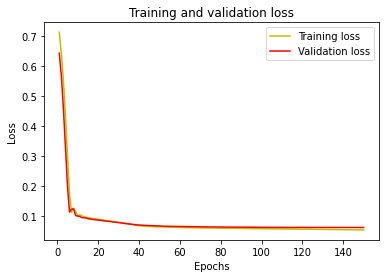

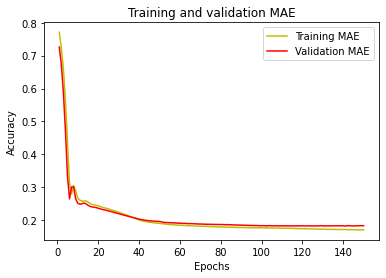

In [155]:
with tf.device('/device:GPU:0'):
    model1 = Sequential()
    model1.add(Dense(128,input_dim=13,activation='sigmoid'))
    model1.add(Dense(64, activation='relu'))
    model1.add(Dense(30,activation='relu'))
    model1.add(Dense(20,activation='relu'))
    model1.add(Dense(5,activation='relu'))
    model1.add(Dense(5,activation='relu'))
    model1.add(Dense(10,activation='relu'))
    model1.add(Dense(15,activation='relu'))
    model1.add(Dense(5,activation='relu'))
    model1.add(Dense(1,activation='linear'))
    model1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
    model1.summary()
    history = model1.fit(X_train,Y_train,epochs=150,validation_split=0.2,batch_size=220, verbose=1, shuffle=False)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Training loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['mae']
    val_acc = history.history['val_mae']
    plt.plot(epochs,acc,'y',label='Training MAE')
    plt.plot(epochs,val_acc,'r',label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [184]:
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = model1

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

10/10 [==============================] - 0s 1ms/step


In [186]:
CV = []
for i in range(100):
    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20) 
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    with tf.device('/device:GPU:0'):
      def create_network():
        model1 = Sequential()
        model1.add(Dense(128,input_dim=13,activation='sigmoid'))
        model1.add(Dense(64, activation='relu'))
        model1.add(Dense(30,activation='relu'))
        model1.add(Dense(20,activation='relu'))
        model1.add(Dense(5,activation='relu'))
        model1.add(Dense(5,activation='relu'))
        model1.add(Dense(10,activation='relu'))
        model1.add(Dense(15,activation='relu'))
        model1.add(Dense(5,activation='relu'))
        model1.add(Dense(1,activation='linear'))
        model1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
        return model1
    # Envolver el modelo de Keras para que pueda ser utilizado por Sklearn
    neural_network = KerasRegressor(build_fn= create_network,epochs=150,validation_split=0.2) 
    # Cross Validation Score
    cv_regressor =cross_val_score(neural_network, X = X_train, y = Y_train, cv = 5,scoring='r2',n_jobs=1)
    CV.append(cv_regressor.mean())

Epoch 1/150
24/24 [==============================] - 1s 9ms/step - loss: 0.6985 - mae: 0.7624 - val_loss: 0.7910 - val_mae: 0.8137
Epoch 2/150
24/24 [==============================] - 0s 3ms/step - loss: 0.6617 - mae: 0.7378 - val_loss: 0.7530 - val_mae: 0.7901
Epoch 3/150
24/24 [==============================] - 0s 3ms/step - loss: 0.6276 - mae: 0.7143 - val_loss: 0.7168 - val_mae: 0.7668
Epoch 4/150
24/24 [==============================] - 0s 4ms/step - loss: 0.5952 - mae: 0.6913 - val_loss: 0.6822 - val_mae: 0.7439
Epoch 5/150
24/24 [==============================] - 0s 3ms/step - loss: 0.5644 - mae: 0.6686 - val_loss: 0.6492 - val_mae: 0.7214
Epoch 6/150
24/24 [==============================] - 0s 4ms/step - loss: 0.5350 - mae: 0.6464 - val_loss: 0.6179 - val_mae: 0.6993
Epoch 7/150
24/24 [==============================] - 0s 4ms/step - loss: 0.5070 - mae: 0.6248 - val_loss: 0.5884 - val_mae: 0.6779
Epoch 8/150
24/24 [==============================] - 0s 4ms/step - loss: 0.4809 - m

In [188]:
# Guardando las 100 repeticiones en un pandas dataframe
metricsmlp=pd.DataFrame({'cv_mlp':CV,
                        'r2_score_mlp_train':R2train,
                        'r2_score_mlp_test':R2test,
                        'mse_mlp':MSE,
                        'rmse_mlp':RMSE,
                        'mae_mlp':MAE})
metricsmlp

,cv_mlp,r2_score_mlp_train,r2_score_mlp_test,mse_mlp,rmse_mlp,mae_mlp
0,0.340167,0.541827,0.570423,0.052119,0.228296,0.171829
1,0.325443,0.544472,0.550621,0.045684,0.213737,0.165040


In [ ]:
metricsmlp.to_csv('100 repeticiones mlp.csv', encoding = 'utf-8-sig') 
files.download('100 repeticiones mlp.csv')

<Figure size 432x288 with 0 Axes>

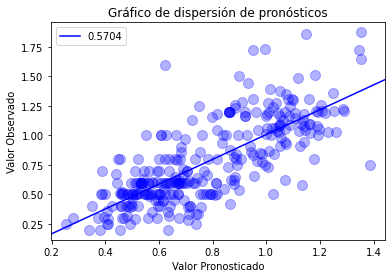

In [189]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos")
plt.legend()
plt.show()

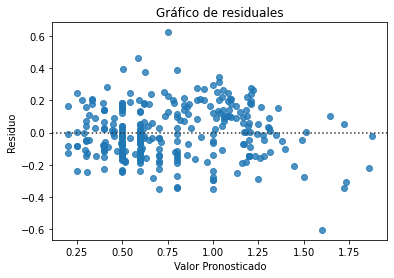

In [190]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales")
plt.show()

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   1%|          | 3/300 [00:00<?, ?it/s]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   2%|▏         | 5/300 [00:14<07:33,  1.54s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   2%|▏         | 6/300 [00:17<10:52,  2.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   2%|▏         | 7/300 [00:20<12:20,  2.53s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   3%|▎         | 8/300 [00:24<13:48,  2.84s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   3%|▎         | 9/300 [00:27<14:16,  2.94s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:   3%|▎         | 10/300 [00:30<14:54,  3.09s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   4%|▎         | 11/300 [00:34<15:53,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   4%|▍         | 12/300 [00:37<15:30,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   4%|▍         | 13/300 [00:40<15:31,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   5%|▍         | 14/300 [00:43<15:19,  3.21s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   5%|▌         | 15/300 [00:47<15:22,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   5%|▌         | 16/300 [00:50<15:08,  3.20s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   6%|▌         | 17/300 [00:53<15:10,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   6%|▌         | 18/300 [00:56<15:19,  3.26s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   6%|▋         | 19/300 [01:00<15:14,  3.26s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   7%|▋         | 20/300 [01:03<15:10,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   7%|▋         | 21/300 [01:06<14:47,  3.18s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   7%|▋         | 22/300 [01:09<14:45,  3.18s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   8%|▊         | 23/300 [01:12<14:36,  3.17s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   8%|▊         | 24/300 [01:15<14:41,  3.19s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   8%|▊         | 25/300 [01:19<14:38,  3.19s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   9%|▊         | 26/300 [01:22<14:24,  3.16s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   9%|▉         | 27/300 [01:25<14:15,  3.13s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:   9%|▉         | 28/300 [01:28<14:16,  3.15s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  10%|▉         | 29/300 [01:31<14:08,  3.13s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  10%|█         | 30/300 [01:34<14:07,  3.14s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  10%|█         | 31/300 [01:38<14:18,  3.19s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  11%|█         | 32/300 [01:41<14:16,  3.20s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  11%|█         | 33/300 [01:44<14:16,  3.21s/it]

42/42 [==============================] - 0s 1ms/step


Permutation explainer:  11%|█▏        | 34/300 [01:47<14:19,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  12%|█▏        | 35/300 [01:51<14:23,  3.26s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  12%|█▏        | 36/300 [01:54<14:27,  3.29s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  12%|█▏        | 37/300 [01:57<14:14,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  13%|█▎        | 38/300 [02:01<14:49,  3.40s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  13%|█▎        | 39/300 [02:04<14:33,  3.35s/it]

42/42 [==============================] - 0s 1ms/step


Permutation explainer:  13%|█▎        | 40/300 [02:07<14:19,  3.31s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  14%|█▎        | 41/300 [02:11<14:12,  3.29s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  14%|█▍        | 42/300 [02:14<13:50,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  14%|█▍        | 43/300 [02:17<13:53,  3.25s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  15%|█▍        | 44/300 [02:20<13:38,  3.20s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  15%|█▌        | 45/300 [02:23<13:45,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  15%|█▌        | 46/300 [02:26<13:31,  3.20s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  16%|█▌        | 47/300 [02:30<13:35,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  16%|█▌        | 48/300 [02:33<13:23,  3.19s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  16%|█▋        | 49/300 [02:36<13:25,  3.21s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  17%|█▋        | 50/300 [02:39<13:27,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  17%|█▋        | 51/300 [02:43<13:23,  3.23s/it]

44/44 [==============================] - 0s 965us/step


Permutation explainer:  17%|█▋        | 52/300 [02:46<13:09,  3.18s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  18%|█▊        | 53/300 [02:49<13:03,  3.17s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  18%|█▊        | 54/300 [02:52<12:58,  3.17s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  18%|█▊        | 55/300 [02:55<13:04,  3.20s/it]

42/42 [==============================] - 0s 1ms/step


Permutation explainer:  19%|█▊        | 56/300 [02:58<13:02,  3.21s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  19%|█▉        | 57/300 [03:02<13:01,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  19%|█▉        | 58/300 [03:05<13:05,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  20%|█▉        | 59/300 [03:08<13:00,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  20%|██        | 60/300 [03:11<12:51,  3.21s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  20%|██        | 61/300 [03:15<12:57,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  21%|██        | 62/300 [03:18<12:50,  3.24s/it]

44/44 [==============================] - 0s 980us/step


Permutation explainer:  21%|██        | 63/300 [03:21<12:43,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  21%|██▏       | 64/300 [03:24<12:30,  3.18s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  22%|██▏       | 65/300 [03:27<12:29,  3.19s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  22%|██▏       | 66/300 [03:31<12:34,  3.22s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  22%|██▏       | 67/300 [03:34<12:27,  3.21s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  23%|██▎       | 68/300 [03:37<12:21,  3.20s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  23%|██▎       | 69/300 [03:40<12:28,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  23%|██▎       | 70/300 [03:44<12:16,  3.20s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  24%|██▎       | 71/300 [03:47<12:11,  3.20s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  24%|██▍       | 72/300 [03:50<12:17,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  24%|██▍       | 73/300 [03:53<12:29,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  25%|██▍       | 74/300 [03:57<12:46,  3.39s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  25%|██▌       | 75/300 [04:00<12:35,  3.36s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  25%|██▌       | 76/300 [04:03<12:13,  3.27s/it]

44/44 [==============================] - 0s 947us/step


Permutation explainer:  26%|██▌       | 77/300 [04:07<12:00,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  26%|██▌       | 78/300 [04:10<11:57,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  26%|██▋       | 79/300 [04:13<12:00,  3.26s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  27%|██▋       | 80/300 [04:16<11:50,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  27%|██▋       | 81/300 [04:19<11:44,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  27%|██▋       | 82/300 [04:23<11:41,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  28%|██▊       | 83/300 [04:26<11:36,  3.21s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  28%|██▊       | 84/300 [04:29<11:40,  3.24s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  28%|██▊       | 85/300 [04:33<11:44,  3.28s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  29%|██▊       | 86/300 [04:36<12:05,  3.39s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  29%|██▉       | 87/300 [04:39<11:43,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  29%|██▉       | 88/300 [04:43<11:40,  3.30s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  30%|██▉       | 89/300 [04:46<11:30,  3.27s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  30%|███       | 90/300 [04:49<11:21,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  30%|███       | 91/300 [04:52<11:19,  3.25s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  31%|███       | 92/300 [04:55<11:11,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  31%|███       | 93/300 [04:59<10:59,  3.18s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  31%|███▏      | 94/300 [05:02<10:54,  3.18s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  32%|███▏      | 95/300 [05:05<10:46,  3.16s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  32%|███▏      | 96/300 [05:08<10:48,  3.18s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  32%|███▏      | 97/300 [05:11<10:49,  3.20s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  33%|███▎      | 98/300 [05:14<10:43,  3.19s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  33%|███▎      | 99/300 [05:18<10:39,  3.18s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  33%|███▎      | 100/300 [05:21<10:36,  3.18s/it]

43/43 [==============================] - 0s 2ms/step


Permutation explainer:  34%|███▎      | 101/300 [05:24<10:40,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  34%|███▍      | 102/300 [05:27<10:40,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  34%|███▍      | 103/300 [05:31<10:32,  3.21s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  35%|███▍      | 104/300 [05:34<10:27,  3.20s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  35%|███▌      | 105/300 [05:37<10:28,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  35%|███▌      | 106/300 [05:40<10:23,  3.22s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  36%|███▌      | 107/300 [05:43<10:24,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  36%|███▌      | 108/300 [05:47<10:27,  3.27s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  36%|███▋      | 109/300 [05:51<11:05,  3.48s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  37%|███▋      | 110/300 [05:54<10:46,  3.40s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  37%|███▋      | 111/300 [05:57<10:27,  3.32s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  37%|███▋      | 112/300 [06:00<10:14,  3.27s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  38%|███▊      | 113/300 [06:03<10:05,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  38%|███▊      | 114/300 [06:07<10:14,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  38%|███▊      | 115/300 [06:10<10:00,  3.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  39%|███▊      | 116/300 [06:13<09:57,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  39%|███▉      | 117/300 [06:17<09:54,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  39%|███▉      | 118/300 [06:20<09:44,  3.21s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  40%|███▉      | 119/300 [06:23<09:48,  3.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  40%|████      | 120/300 [06:26<09:40,  3.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  40%|████      | 121/300 [06:29<09:41,  3.25s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  41%|████      | 122/300 [06:33<09:40,  3.26s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  41%|████      | 123/300 [06:36<09:41,  3.29s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  41%|████▏     | 124/300 [06:39<09:36,  3.28s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  42%|████▏     | 125/300 [06:43<09:37,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  42%|████▏     | 126/300 [06:46<09:37,  3.32s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  42%|████▏     | 127/300 [06:50<09:43,  3.37s/it]

42/42 [==============================] - 0s 1ms/step


Permutation explainer:  43%|████▎     | 128/300 [06:53<09:36,  3.35s/it]

42/42 [==============================] - 0s 1ms/step


Permutation explainer:  43%|████▎     | 129/300 [06:56<09:34,  3.36s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  43%|████▎     | 130/300 [06:59<09:25,  3.33s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  44%|████▎     | 131/300 [07:03<09:17,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  44%|████▍     | 132/300 [07:06<09:14,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  44%|████▍     | 133/300 [07:09<09:13,  3.31s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  45%|████▍     | 134/300 [07:13<09:06,  3.29s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  45%|████▌     | 135/300 [07:16<08:58,  3.26s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  45%|████▌     | 136/300 [07:19<09:01,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  46%|████▌     | 137/300 [07:22<08:53,  3.28s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  46%|████▌     | 138/300 [07:26<08:49,  3.27s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  46%|████▋     | 139/300 [07:29<08:58,  3.34s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  47%|████▋     | 140/300 [07:32<08:50,  3.32s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  47%|████▋     | 141/300 [07:36<08:43,  3.29s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  47%|████▋     | 142/300 [07:39<08:40,  3.30s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  48%|████▊     | 143/300 [07:43<09:13,  3.52s/it]

44/44 [==============================] - 0s 5ms/step


Permutation explainer:  48%|████▊     | 144/300 [07:50<11:55,  4.59s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  48%|████▊     | 145/300 [07:55<12:08,  4.70s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  49%|████▊     | 146/300 [07:58<11:03,  4.31s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  49%|████▉     | 147/300 [08:04<11:54,  4.67s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  49%|████▉     | 148/300 [08:07<10:53,  4.30s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  50%|████▉     | 149/300 [08:11<10:03,  4.00s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  50%|█████     | 150/300 [08:14<09:31,  3.81s/it]

44/44 [==============================] - 0s 987us/step


Permutation explainer:  50%|█████     | 151/300 [08:17<09:03,  3.65s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  51%|█████     | 152/300 [08:22<09:26,  3.83s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  51%|█████     | 153/300 [08:25<08:58,  3.66s/it]

44/44 [==============================] - 0s 4ms/step


Permutation explainer:  51%|█████▏    | 154/300 [08:32<11:11,  4.60s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  52%|█████▏    | 155/300 [08:38<12:04,  5.00s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  52%|█████▏    | 156/300 [08:46<14:36,  6.08s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  52%|█████▏    | 157/300 [08:50<12:32,  5.26s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  53%|█████▎    | 158/300 [08:53<10:59,  4.64s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  53%|█████▎    | 159/300 [08:56<10:04,  4.29s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  53%|█████▎    | 160/300 [09:00<09:20,  4.00s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  54%|█████▎    | 161/300 [09:03<09:04,  3.92s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  54%|█████▍    | 162/300 [09:07<08:37,  3.75s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  54%|█████▍    | 163/300 [09:10<08:26,  3.70s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  55%|█████▍    | 164/300 [09:13<08:05,  3.57s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  55%|█████▌    | 165/300 [09:17<07:50,  3.49s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  55%|█████▌    | 166/300 [09:20<07:35,  3.40s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  56%|█████▌    | 167/300 [09:24<07:42,  3.47s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  56%|█████▌    | 168/300 [09:27<07:31,  3.42s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  56%|█████▋    | 169/300 [09:30<07:24,  3.39s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  57%|█████▋    | 170/300 [09:34<07:18,  3.38s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  57%|█████▋    | 171/300 [09:38<08:10,  3.80s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  57%|█████▋    | 172/300 [09:42<07:46,  3.64s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  58%|█████▊    | 173/300 [09:46<08:19,  3.94s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  58%|█████▊    | 174/300 [09:50<07:53,  3.76s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  58%|█████▊    | 175/300 [09:53<07:31,  3.61s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  59%|█████▊    | 176/300 [09:57<07:31,  3.64s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  59%|█████▉    | 177/300 [10:00<07:14,  3.53s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  59%|█████▉    | 178/300 [10:03<07:04,  3.48s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  60%|█████▉    | 179/300 [10:06<06:52,  3.41s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  60%|██████    | 180/300 [10:10<06:44,  3.37s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  60%|██████    | 181/300 [10:13<06:45,  3.40s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  61%|██████    | 182/300 [10:17<06:41,  3.40s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  61%|██████    | 183/300 [10:22<07:40,  3.93s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  61%|██████▏   | 184/300 [10:29<09:29,  4.91s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  62%|██████▏   | 185/300 [10:32<08:24,  4.39s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  62%|██████▏   | 186/300 [10:37<08:37,  4.54s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  62%|██████▏   | 187/300 [10:41<08:02,  4.27s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  63%|██████▎   | 188/300 [10:44<07:25,  3.97s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  63%|██████▎   | 189/300 [10:51<08:57,  4.84s/it]

43/43 [==============================] - 0s 2ms/step


Permutation explainer:  63%|██████▎   | 190/300 [10:58<10:03,  5.49s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  64%|██████▎   | 191/300 [11:05<10:39,  5.87s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  64%|██████▍   | 192/300 [11:08<09:29,  5.27s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  64%|██████▍   | 193/300 [11:12<08:29,  4.76s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  65%|██████▍   | 194/300 [11:15<07:38,  4.33s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  65%|██████▌   | 195/300 [11:19<07:07,  4.08s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  65%|██████▌   | 196/300 [11:22<06:35,  3.80s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  66%|██████▌   | 197/300 [11:25<06:16,  3.66s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  66%|██████▌   | 198/300 [11:29<06:03,  3.57s/it]

42/42 [==============================] - 0s 1ms/step


Permutation explainer:  66%|██████▋   | 199/300 [11:33<06:17,  3.73s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  67%|██████▋   | 200/300 [11:36<06:05,  3.65s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  67%|██████▋   | 201/300 [11:42<06:52,  4.17s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  67%|██████▋   | 202/300 [11:45<06:23,  3.91s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  68%|██████▊   | 203/300 [11:48<05:59,  3.71s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  68%|██████▊   | 204/300 [11:51<05:45,  3.60s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  68%|██████▊   | 205/300 [11:55<05:46,  3.65s/it]

44/44 [==============================] - 0s 3ms/step


Permutation explainer:  69%|██████▊   | 206/300 [12:03<07:31,  4.81s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  69%|██████▉   | 207/300 [12:07<07:02,  4.54s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  69%|██████▉   | 208/300 [12:10<06:28,  4.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  70%|██████▉   | 209/300 [12:14<06:05,  4.02s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  70%|███████   | 210/300 [12:17<05:50,  3.90s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  70%|███████   | 211/300 [12:21<05:31,  3.72s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  71%|███████   | 212/300 [12:24<05:24,  3.69s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  71%|███████   | 213/300 [12:28<05:10,  3.57s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  71%|███████▏  | 214/300 [12:31<05:13,  3.65s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  72%|███████▏  | 215/300 [12:35<04:58,  3.51s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  72%|███████▏  | 216/300 [12:38<04:47,  3.42s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  72%|███████▏  | 217/300 [12:41<04:41,  3.39s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  73%|███████▎  | 218/300 [12:45<04:41,  3.43s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  73%|███████▎  | 219/300 [12:48<04:38,  3.43s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  73%|███████▎  | 220/300 [12:51<04:34,  3.43s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  74%|███████▎  | 221/300 [12:55<04:27,  3.39s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  74%|███████▍  | 222/300 [12:59<04:44,  3.64s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  74%|███████▍  | 223/300 [13:03<04:39,  3.62s/it]

42/42 [==============================] - 0s 1ms/step


Permutation explainer:  75%|███████▍  | 224/300 [13:06<04:27,  3.52s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  75%|███████▌  | 225/300 [13:09<04:24,  3.53s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  75%|███████▌  | 226/300 [13:13<04:16,  3.47s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  76%|███████▌  | 227/300 [13:16<04:11,  3.45s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  76%|███████▌  | 228/300 [13:20<04:06,  3.43s/it]

43/43 [==============================] - 0s 2ms/step


Permutation explainer:  76%|███████▋  | 229/300 [13:28<05:50,  4.93s/it]

43/43 [==============================] - 0s 4ms/step


Permutation explainer:  77%|███████▋  | 230/300 [13:35<06:33,  5.62s/it]

44/44 [==============================] - 0s 3ms/step


Permutation explainer:  77%|███████▋  | 231/300 [13:44<07:33,  6.57s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  77%|███████▋  | 232/300 [13:50<07:22,  6.50s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  78%|███████▊  | 233/300 [14:00<08:21,  7.48s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  78%|███████▊  | 234/300 [14:07<07:57,  7.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  78%|███████▊  | 235/300 [14:10<06:34,  6.07s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  79%|███████▊  | 236/300 [14:13<05:34,  5.23s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  79%|███████▉  | 237/300 [14:17<04:58,  4.74s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  79%|███████▉  | 238/300 [14:20<04:28,  4.32s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  80%|███████▉  | 239/300 [14:24<04:10,  4.10s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  80%|████████  | 240/300 [14:27<03:54,  3.91s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  80%|████████  | 241/300 [14:31<03:39,  3.72s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  81%|████████  | 242/300 [14:34<03:37,  3.76s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  81%|████████  | 243/300 [14:38<03:28,  3.66s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  81%|████████▏ | 244/300 [14:41<03:20,  3.58s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  82%|████████▏ | 245/300 [14:45<03:15,  3.55s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  82%|████████▏ | 246/300 [14:48<03:10,  3.53s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  82%|████████▏ | 247/300 [14:52<03:05,  3.50s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  83%|████████▎ | 248/300 [14:55<03:03,  3.53s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  83%|████████▎ | 249/300 [14:59<03:01,  3.55s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  83%|████████▎ | 250/300 [15:02<02:54,  3.49s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  84%|████████▎ | 251/300 [15:06<02:48,  3.45s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  84%|████████▍ | 252/300 [15:09<02:43,  3.41s/it]

43/43 [==============================] - 0s 2ms/step


Permutation explainer:  84%|████████▍ | 253/300 [15:12<02:38,  3.37s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  85%|████████▍ | 254/300 [15:16<02:35,  3.37s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  85%|████████▌ | 255/300 [15:19<02:31,  3.36s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  85%|████████▌ | 256/300 [15:24<02:50,  3.87s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  86%|████████▌ | 257/300 [15:27<02:40,  3.74s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  86%|████████▌ | 258/300 [15:31<02:31,  3.62s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  86%|████████▋ | 259/300 [15:36<02:43,  3.99s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  87%|████████▋ | 260/300 [15:39<02:31,  3.80s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  87%|████████▋ | 261/300 [15:42<02:22,  3.66s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  87%|████████▋ | 262/300 [15:46<02:17,  3.62s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  88%|████████▊ | 263/300 [15:49<02:12,  3.57s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  88%|████████▊ | 264/300 [15:53<02:08,  3.56s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  88%|████████▊ | 265/300 [15:56<02:01,  3.48s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  89%|████████▊ | 266/300 [15:59<01:56,  3.43s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  89%|████████▉ | 267/300 [16:03<01:51,  3.39s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  89%|████████▉ | 268/300 [16:06<01:48,  3.41s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  90%|████████▉ | 269/300 [16:09<01:44,  3.37s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  90%|█████████ | 270/300 [16:13<01:43,  3.45s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  90%|█████████ | 271/300 [16:18<01:56,  4.02s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  91%|█████████ | 272/300 [16:24<02:05,  4.47s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  91%|█████████ | 273/300 [16:27<01:52,  4.16s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  91%|█████████▏| 274/300 [16:31<01:43,  3.98s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  92%|█████████▏| 275/300 [16:34<01:35,  3.81s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  92%|█████████▏| 276/300 [16:38<01:29,  3.72s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  92%|█████████▏| 277/300 [16:43<01:31,  3.99s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  93%|█████████▎| 278/300 [16:46<01:24,  3.86s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  93%|█████████▎| 279/300 [16:53<01:38,  4.71s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  93%|█████████▎| 280/300 [16:58<01:37,  4.88s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  94%|█████████▎| 281/300 [17:04<01:37,  5.13s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  94%|█████████▍| 282/300 [17:07<01:23,  4.62s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  94%|█████████▍| 283/300 [17:11<01:12,  4.24s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  95%|█████████▍| 284/300 [17:14<01:03,  3.97s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  95%|█████████▌| 285/300 [17:18<01:00,  4.04s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  95%|█████████▌| 286/300 [17:23<00:59,  4.25s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  96%|█████████▌| 287/300 [17:26<00:51,  3.99s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  96%|█████████▌| 288/300 [17:34<01:02,  5.24s/it]

44/44 [==============================] - 0s 4ms/step


Permutation explainer:  96%|█████████▋| 289/300 [17:43<01:10,  6.38s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  97%|█████████▋| 290/300 [17:47<00:56,  5.64s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  97%|█████████▋| 291/300 [17:51<00:45,  5.02s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  97%|█████████▋| 292/300 [17:56<00:41,  5.14s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  98%|█████████▊| 293/300 [18:01<00:34,  4.86s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  98%|█████████▊| 294/300 [18:04<00:27,  4.57s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  98%|█████████▊| 295/300 [18:08<00:21,  4.25s/it]

44/44 [==============================] - 0s 2ms/step


Permutation explainer:  99%|█████████▊| 296/300 [18:11<00:15,  3.99s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer:  99%|█████████▉| 297/300 [18:15<00:11,  3.82s/it]

43/43 [==============================] - 0s 1ms/step


Permutation explainer:  99%|█████████▉| 298/300 [18:18<00:07,  3.73s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer: 100%|█████████▉| 299/300 [18:22<00:03,  3.63s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer: 100%|██████████| 300/300 [18:25<00:00,  3.65s/it]

44/44 [==============================] - 0s 1ms/step


Permutation explainer: 301it [18:29,  3.72s/it]


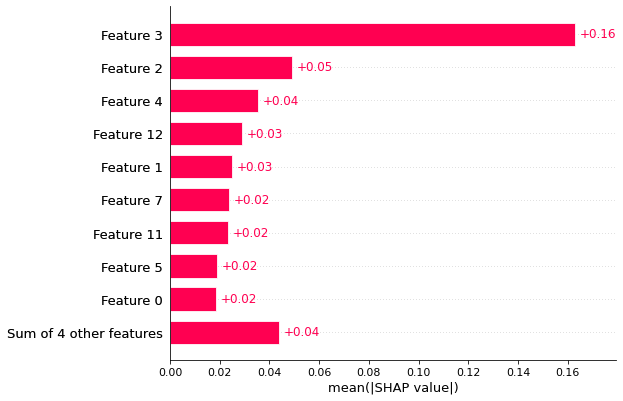

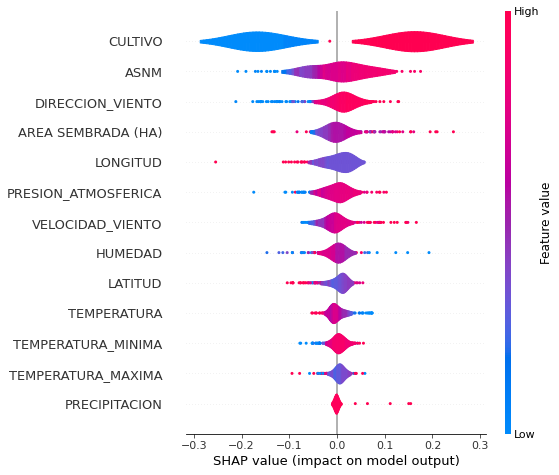

In [191]:
# Shap Values
explainer = shap.Explainer(model1.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Recurrent Neural Network: Long Short Term Memory (LSTM)**

In [196]:
X_train=X_train.reshape(1197,1,13)
Y_train=Y_train.reshape(1197,1,1)
X_test=X_test.reshape(300,1,13)
Y_test=Y_test.reshape(300,1,1)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 10)             960       
                                                                 
 dense_380 (Dense)           (None, 1, 5)              55        
                                                                 
 lstm_1 (LSTM)               (None, 10)                640       
                                                                 
 dense_381 (Dense)           (None, 5)                 55        
                                                                 
 dense_382 (Dense)           (None, 10)                60        
                                                                 
 dense_383 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-train

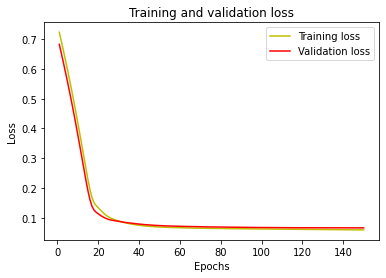

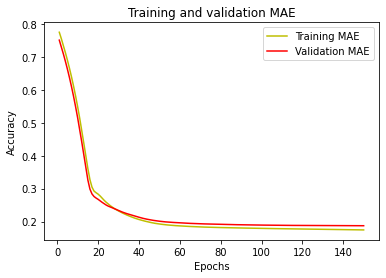

In [197]:
from keras.layers import LSTM
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(LSTM(10,input_shape=(1,13),return_sequences=True, activation='relu'))
  model.add(Dense(5,activation='relu'))
  model.add(LSTM(10,activation='relu'))
  model.add(Dense(5,activation='relu'))
  model.add(Dense(10,activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer="Adam", loss="mse",metrics=["mae"])
  model.summary()
  history = model.fit(X_train,Y_train,validation_split=0.2,epochs=150, batch_size=220, verbose=1, shuffle=False)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1,len(loss)+1)
  plt.plot(epochs,loss,'y',label='Training loss')
  plt.plot(epochs,val_loss,'r',label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  acc = history.history['mae']
  val_acc = history.history['val_mae']
  plt.plot(epochs,acc,'y',label='Training MAE')
  plt.plot(epochs,val_acc,'r',label='Validation MAE')
  plt.title('Training and validation MAE')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [277]:
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    X_train=X_train.reshape(1197,1,13)
    Y_train=Y_train.reshape(1197,1,1)
    X_test=X_test.reshape(300,1,13)
    Y_test=Y_test.reshape(300,1,1)

    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = model

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train).reshape(1197,1)
    Y_train=Y_train.reshape(1197,1)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test).reshape(300,1)
    Y_test=Y_test.reshape(300,1)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

10/10 [==============================] - 0s 2ms/step


In [203]:
CV = []
for i in range(100): 
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    with tf.device('/device:GPU:0'):
      def rnn_model():
        model = Sequential()
        model.add(LSTM(10,input_shape=(1,13),return_sequences=True, activation='relu'))
        model.add(Dense(5,activation='relu'))
        model.add(LSTM(10,activation='relu'))
        model.add(Dense(5,activation='relu'))
        model.add(Dense(10,activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer="Adam", loss="mse",metrics=["mae"])
        return model
    # Envolver el modelo de Keras para que pueda ser utilizado por Sklearn
    rnn_network = KerasRegressor(build_fn= rnn_model,validation_split=0.2,batch_size=220,epochs=150, verbose=1, shuffle=False)
    # Cross Validation Score
    cv_regressor =cross_val_score(rnn_network, X = X_train, y = Y_train, cv = 5,scoring='r2',n_jobs=1)
    CV.append(cv_regressor.mean())

Epoch 1/150
4/4 [==============================] - 6s 192ms/step - loss: 0.7409 - mae: 0.7843 - val_loss: 0.7190 - val_mae: 0.7684
Epoch 2/150
4/4 [==============================] - 0s 10ms/step - loss: 0.7278 - mae: 0.7759 - val_loss: 0.7070 - val_mae: 0.7607
Epoch 3/150
4/4 [==============================] - 0s 11ms/step - loss: 0.7158 - mae: 0.7682 - val_loss: 0.6948 - val_mae: 0.7527
Epoch 4/150
4/4 [==============================] - 0s 11ms/step - loss: 0.7035 - mae: 0.7602 - val_loss: 0.6823 - val_mae: 0.7443
Epoch 5/150
4/4 [==============================] - 0s 13ms/step - loss: 0.6907 - mae: 0.7517 - val_loss: 0.6695 - val_mae: 0.7356
Epoch 6/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6776 - mae: 0.7430 - val_loss: 0.6563 - val_mae: 0.7266
Epoch 7/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6643 - mae: 0.7339 - val_loss: 0.6429 - val_mae: 0.7172
Epoch 8/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6507 - mae: 0.7

2/2 [==============================] - 0s 5ms/step
Epoch 1/150
4/4 [==============================] - 7s 187ms/step - loss: 0.7306 - mae: 0.7793 - val_loss: 0.7186 - val_mae: 0.7678
Epoch 2/150
4/4 [==============================] - 0s 9ms/step - loss: 0.7110 - mae: 0.7667 - val_loss: 0.6987 - val_mae: 0.7548
Epoch 3/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6911 - mae: 0.7536 - val_loss: 0.6783 - val_mae: 0.7413
Epoch 4/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6706 - mae: 0.7400 - val_loss: 0.6572 - val_mae: 0.7271
Epoch 5/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6494 - mae: 0.7257 - val_loss: 0.6353 - val_mae: 0.7120
Epoch 6/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6274 - mae: 0.7105 - val_loss: 0.6124 - val_mae: 0.6959
Epoch 7/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6044 - mae: 0.6944 - val_loss: 0.5884 - val_mae: 0.6787
Epoch 8/150
4/4 [======================

2/2 [==============================] - 0s 9ms/step
Epoch 1/150
4/4 [==============================] - 3s 128ms/step - loss: 0.7365 - mae: 0.7814 - val_loss: 0.7133 - val_mae: 0.7645
Epoch 2/150
4/4 [==============================] - 0s 9ms/step - loss: 0.7224 - mae: 0.7722 - val_loss: 0.6987 - val_mae: 0.7548
Epoch 3/150
4/4 [==============================] - 0s 10ms/step - loss: 0.7074 - mae: 0.7625 - val_loss: 0.6835 - val_mae: 0.7447
Epoch 4/150
4/4 [==============================] - 0s 10ms/step - loss: 0.6918 - mae: 0.7522 - val_loss: 0.6679 - val_mae: 0.7341
Epoch 5/150
4/4 [==============================] - 0s 10ms/step - loss: 0.6757 - mae: 0.7414 - val_loss: 0.6518 - val_mae: 0.7231
Epoch 6/150
4/4 [==============================] - 0s 10ms/step - loss: 0.6593 - mae: 0.7302 - val_loss: 0.6353 - val_mae: 0.7115
Epoch 7/150
4/4 [==============================] - 0s 11ms/step - loss: 0.6424 - mae: 0.7185 - val_loss: 0.6183 - val_mae: 0.6994
Epoch 8/150
4/4 [======================

In [204]:
# Guardando las 100 repeticiones en un pandas dataframe
metricslstm=pd.DataFrame({'cv_lstm':CV,
                        'r2_score_lstm_train':R2train,
                        'r2_score_lstm_test':R2test,
                        'mse_lstm':MSE,
                        'rmse_lstm':RMSE,
                        'mae_lstm':MAE})
metricslstm

,cv_lstm,r2_score_lstm_train,r2_score_lstm_test,mse_lstm,rmse_lstm,mae_lstm
0,0.414449,0.494791,0.498789,0.060496,0.245959,0.183958
1,0.417451,0.496196,0.517595,0.051519,0.226977,0.171469


In [ ]:
metricslstm.to_csv('100 repeticiones lstm.csv', encoding = 'utf-8-sig') 
files.download('100 repeticiones lstm.csv')

<Figure size 432x288 with 0 Axes>

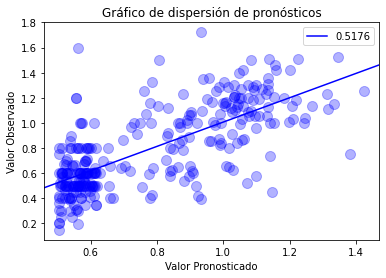

In [205]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos")
plt.legend()
plt.show()

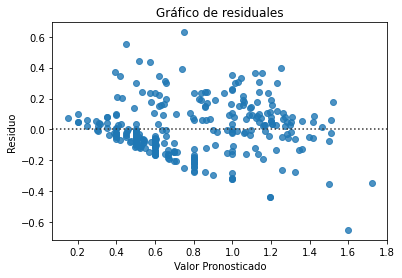

In [206]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales")
plt.show()

In [285]:
with tf.device('/device:GPU:0'):
  def rnn_model():
    model = Sequential()
    model.add(LSTM(10,input_shape=(1,13),return_sequences=True, activation='relu'))
    model.add(Dense(5,activation='relu'))
    model.add(LSTM(10,activation='relu'))
    model.add(Dense(5,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse",metrics=["mae"])
    return model
    # Envolver el modelo de Keras para que pueda ser utilizado por Sklearn
    rnn_network = KerasRegressor(build_fn= rnn_model,validation_split=0.2,batch_size=220,epochs=150, verbose=1, shuffle=False)

**Comparación de modelos**

***Valores promedio de las 100 repeticiones por modelo***

In [300]:
# DataFrame valores promedio de las 100 repeticiones
modelsmean = [('Linear Regression',metricslr['mae_lr'].mean(), metricslr['mse_lr'].mean(), metricslr['rmse_lr'].mean(), metricslr['r2_score_lr_train'].mean(), metricslr['r2_score_lr_test'].mean(), metricslr['cv_lr'].mean()),
          ('Decision Tree',metricsdt['mae_dt'].mean(), metricsdt['mse_dt'].mean(), metricsdt['rmse_dt'].mean(), metricsdt['r2_score_dt_train'].mean(), metricsdt['r2_score_dt_test'].mean(), metricsdt['cv_dt'].mean()),
          ('Support Vector Regression',metricssvr['mae_svr'].mean(), metricssvr['mse_svr'].mean(), metricssvr['rmse_svr'].mean(), metricssvr['r2_score_svr_train'].mean(), metricssvr['r2_score_svr_test'].mean(), metricssvr['cv_svr'].mean()),
          ('XGBoost',metricsxgbr['mae_xgbr'].mean(), metricsxgbr['mse_xgbr'].mean(), metricsxgbr['rmse_xgbr'].mean(), metricsxgbr['r2_score_xgbr_train'].mean(), metricsxgbr['r2_score_xgbr_test'].mean(), metricsxgbr['cv_xgbr'].mean()), 
          ('Random Forest',metricsrf['mae_rf'].mean(), metricsrf['mse_rf'].mean(), metricsrf['rmse_rf'].mean(), metricsrf['r2_score_rf_train'].mean(), metricsrf['r2_score_rf_test'].mean(), metricsrf['cv_rf'].mean()),
          ('Multilayer Perceptron',metricsmlp['mae_mlp'].mean(), metricsmlp['mse_mlp'].mean(), metricsmlp['rmse_mlp'].mean(), metricsmlp['r2_score_mlp_train'].mean(), metricsmlp['r2_score_mlp_test'].mean(), metricsmlp['cv_mlp'].mean()),
          ('LSTM Recurrent Network',metricslstm['mae_lstm'].mean(), metricslstm['mse_lstm'].mean(), metricslstm['rmse_lstm'].mean(), metricslstm['r2_score_lstm_train'].mean(), metricslstm['r2_score_lstm_test'].mean(), metricslstm['cv_lstm'].mean()),
          ]
predictmean = pd.DataFrame(data = modelsmean, columns=['Model','MAE','MSE', 'RMSE', 'R2 (train)', 'R2 (test)', 'Cross-Validation'])
predictmean

,Model,MAE,MSE,RMSE,R2 (train),R2 (test),Cross-Validation
0,Linear Regression,0.198809,0.072629,0.268787,0.431177,0.405674,0.416341
1,Decision Tree,0.195214,0.079076,0.278911,0.597526,0.343566,0.380797
2,Support Vector Regression,0.178315,0.062406,0.248844,0.632454,0.482801,0.479675
3,XGBoost,0.180061,0.062923,0.249940,0.984854,0.477322,0.524011
4,Random Forest,0.173965,0.057234,0.238486,0.941350,0.524709,0.554964
5,Multilayer Perceptron,0.168434,0.048901,0.221017,0.543150,0.560522,0.332805
6,LSTM Recurrent Network,0.177714,0.056007,0.236468,0.495494,0.508192,0.415950


***Desviación estándar de las 100 repeticiones por modelo***

In [301]:
# DataFrame desviación estándar de las 100 repeticiones
modelsdesvest = [('Linear Regression',metricslr['mae_lr'].std(), metricslr['mse_lr'].std(), metricslr['rmse_lr'].std(), metricslr['r2_score_lr_train'].std(), metricslr['r2_score_lr_test'].std(), metricslr['cv_lr'].std()),
                ('Decision Tree',metricsdt['mae_dt'].std(), metricsdt['mse_dt'].std(), metricsdt['rmse_dt'].std(), metricsdt['r2_score_dt_train'].std(), metricsdt['r2_score_dt_test'].std(), metricsdt['cv_dt'].std()),
                ('Support Vector Regression',metricssvr['mae_svr'].std(), metricssvr['mse_svr'].std(), metricssvr['rmse_svr'].std(), metricssvr['r2_score_svr_train'].std(), metricssvr['r2_score_svr_test'].std(), metricssvr['cv_svr'].std()),
                ('XGBoost',metricsxgbr['mae_xgbr'].std(), metricsxgbr['mse_xgbr'].std(), metricsxgbr['rmse_xgbr'].std(), metricsxgbr['r2_score_xgbr_train'].std(), metricsxgbr['r2_score_xgbr_test'].std(), metricsxgbr['cv_xgbr'].std()), 
                ('Random Forest',metricsrf['mae_rf'].std(), metricsrf['mse_rf'].std(), metricsrf['rmse_rf'].std(), metricsrf['r2_score_rf_train'].std(), metricsrf['r2_score_rf_test'].std(), metricsrf['cv_rf'].std()),
                ]
predictdesvest = pd.DataFrame(data = modelsdesvest, columns=['Model','MAE','MSE', 'RMSE', 'R2 (train)', 'R2 (test)', 'Cross-Validation'])
predictdesvest

,Model,MAE,MSE,RMSE,R2 (train),R2 (test),Cross-Validation
0,Linear Regression,0.008790,0.010813,0.019650,0.012386,0.049348,0.013326
1,Decision Tree,0.015685,0.022206,0.036020,0.015688,0.174534,0.058504
2,Support Vector Regression,0.008838,0.011265,0.022074,0.014582,0.057231,0.019234
3,XGBoost,0.009408,0.010828,0.021387,0.000603,0.070227,0.023578
4,Random Forest,0.008035,0.009320,0.019024,0.002493,0.042850,0.016175


***Gráficos validación cruzada promedio 100 repeticiones***

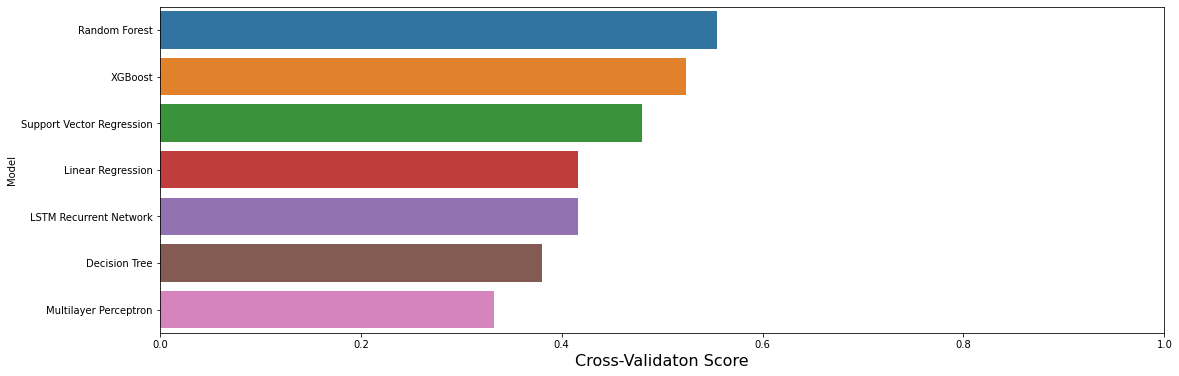

In [303]:
f, axe = plt.subplots(1,1, figsize=(18,6))
predictmean.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)
sns.barplot(x='Cross-Validation', y='Model', data = predictmean, ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

***Gráficos R2 train y test promedio 100 repeticiones***

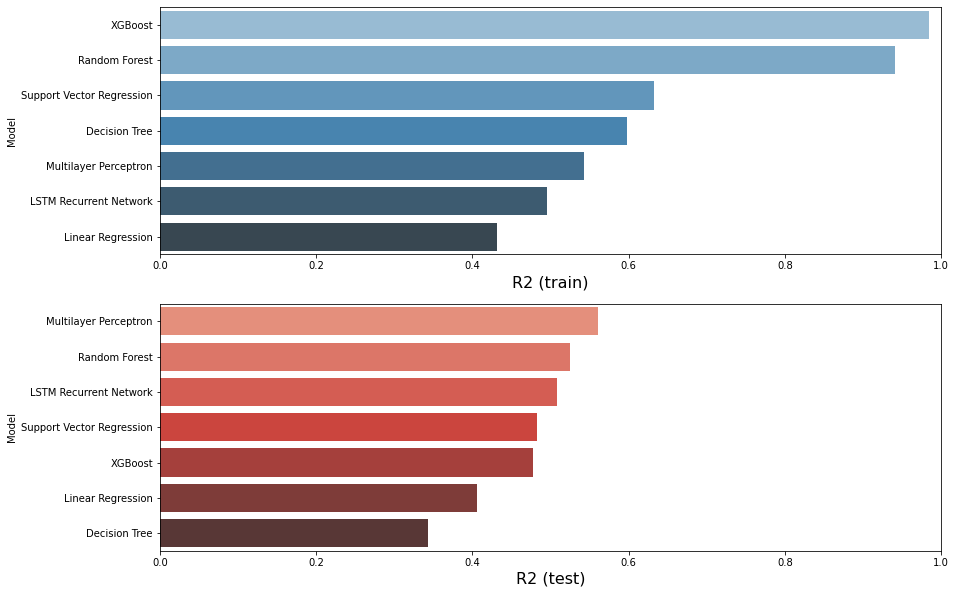

In [305]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predictmean.sort_values(by=['R2 (train)'], ascending=False, inplace=True)

sns.barplot(x='R2 (train)', y='Model', data = predictmean, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 (train)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predictmean.sort_values(by=['R2 (test)'], ascending=False, inplace=True)

sns.barplot(x='R2 (test)', y='Model', data = predictmean, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 (test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()

***ANOVA Cross Validation Score***

In [414]:
# Primero se comprueba que el aprendizaje de los modelos siga un comportamiento normal (en la validación cruzada)
from scipy.stats import kstest, norm
my_data = [metricslr["cv_lr"],metricsdt["cv_dt"],metricssvr["cv_svr"],metricsxgbr["cv_xgbr"],metricsrf["cv_rf"],metricsmlp["cv_mlp"],metricslstm["cv_lstm"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],kstest(i,'norm'))
  pos=pos+1

LR KstestResult(statistic=0.6505699383523945, pvalue=6.887464405776926e-42)
DT KstestResult(statistic=0.5909003158168997, pvalue=8.424207367949618e-34)
SVR KstestResult(statistic=0.6655501722450091, pvalue=3.974746360488882e-44)
XGBR KstestResult(statistic=0.6846955702718199, pvalue=3.9945219438883036e-47)
RF KstestResult(statistic=0.698177407365698, pvalue=2.4662029288525715e-49)
MLP KstestResult(statistic=0.6275771446412162, pvalue=0.2773975663871793)
LSTM KstestResult(statistic=0.6607273883465544, pvalue=0.2302118100362994)


In [415]:
# Aplicamos un test ANOVA para validar si existen diferencias significativas en el aprendizaje, es decir, si existen diferencias significativas entre la capacidad de generalización entre modelos
models_cv = pd.DataFrame.from_dict({'LR': metricslr.cv_lr, 'DT': metricsdt.cv_dt,'SVR': metricssvr.cv_svr,'XGB': metricsxgbr.cv_xgbr,'RF': metricsrf.cv_rf,'MLP': metricsmlp.cv_mlp,'LSTM': metricslstm.cv_lstm}).melt()
models_cv=models_cv.rename(columns={"variable":"Modelo"})
modelo = ols("value  ~ C(Modelo)", data=models_cv).fit()
anova = sm.stats.anova_lm(modelo)
print(anova)

              df    sum_sq   mean_sq         F         PR(>F)
C(Modelo)    6.0  2.150024  0.358337  375.6452  4.557614e-181
Residual   497.0  0.474101  0.000954       NaN            NaN


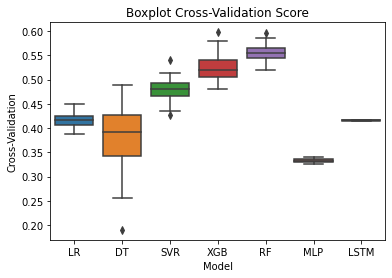

In [416]:
# Los gráficos de boxplot también permitirán ver diferencias entre la distribución de las 100 repeticiones en la validación cruzada (entrenamiento)
sns.boxplot(x="Modelo", y="value",data=models_cv)
plt.xlabel("Model")
plt.ylabel("Cross-Validation")
plt.title("Boxplot Cross-Validation Score")
plt.show()

***Gráficos RMSE promedio 100 repeticiones***

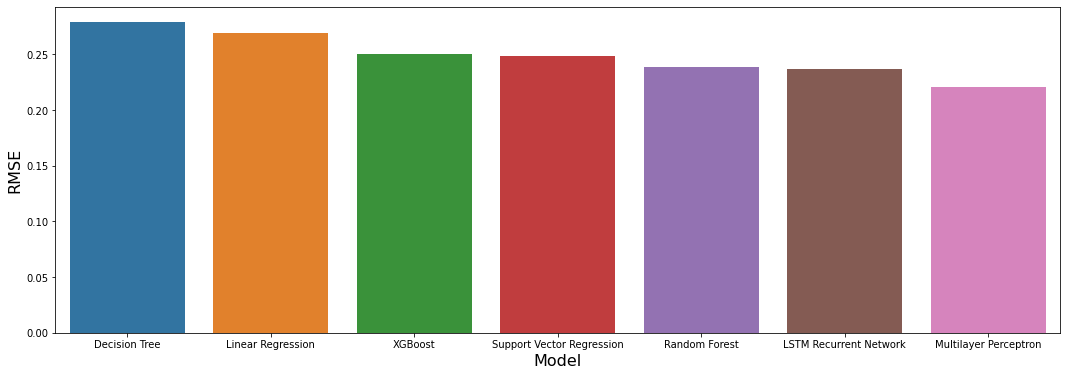

In [307]:
predictmean.sort_values(by=['RMSE'], ascending=False, inplace=True)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predictmean, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)
plt.show()

***Gráficos MSE promedio 100 repeticiones***

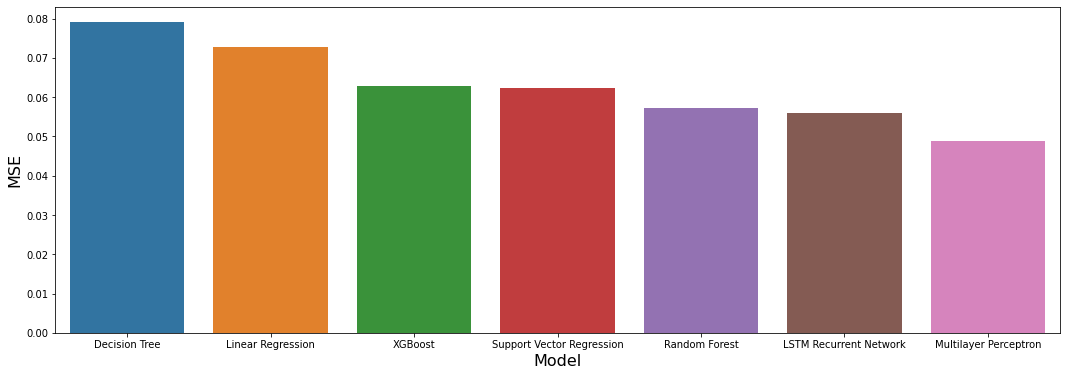

In [308]:
predictmean.sort_values(by=['MSE'], ascending=False, inplace=True)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='MSE', data=predictmean, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('MSE', size=16)
plt.show()

***Gráficos MAE promedio 100 repeticiones***

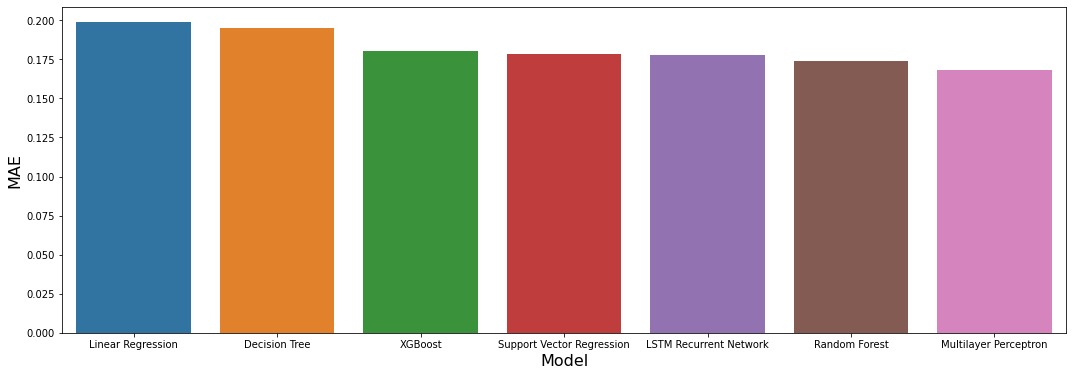

In [309]:
predictmean.sort_values(by=['MAE'], ascending=False, inplace=True)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='MAE', data=predictmean, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('MAE', size=16)
plt.show()

**Normalidad e intervalos de confianza para el ajuste y el error en los modelos**

***Test de normalidad Kolmogorov-Smirnov para el error (MSE)***

In [413]:
from scipy.stats import kstest, norm
my_data = [metricslr["mse_lr"],metricsdt["mse_dt"],metricssvr["mse_svr"],metricsxgbr["mse_xgbr"],metricsrf["mse_rf"],metricsmlp["mse_mlp"],metricslstm["mse_lstm"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],kstest(i,'norm'))
  pos=pos+1

LR KstestResult(statistic=0.5225014959525043, pvalue=6.115093843191061e-26)
DT KstestResult(statistic=0.5185969887754812, pvalue=1.5658989064534166e-25)
SVR KstestResult(statistic=0.5177652800059939, pvalue=1.9108091895586373e-25)
XGBR KstestResult(statistic=0.5184075204525219, pvalue=1.6386068769274813e-25)
RF KstestResult(statistic=0.5163943609174408, pvalue=2.650415184579863e-25)
MLP KstestResult(statistic=0.5182187724963461, pvalue=0.46422630234985507)
LSTM KstestResult(statistic=0.5205438447468719, pvalue=0.4597564096202234)


***Intervalos de confianza para el error (MSE)***

In [408]:
import scipy.stats as st
my_data = [metricslr["mse_lr"],metricsdt["mse_dt"],metricssvr["mse_svr"],metricsxgbr["mse_xgbr"],metricsrf["mse_rf"],metricsmlp["mse_mlp"],metricslstm["mse_lstm"]]
nombres = ["IDC 95% LR","IDC 95% DT","IDC 95% SVR","IDC 95% XGBR","IDC 95% RF","IDC 95% MLP","IDC 95% LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],st.t.interval(alpha=0.95, df=len(i)-1, loc=np.mean(i), scale=st.sem(i)))
  pos=pos+1

IDC 95% LR (0.07048327430408129, 0.07477419895959007)
IDC 95% DT (0.07466966494526375, 0.08348197397223689)
IDC 95% SVR (0.060170657087156, 0.06464122923941053)
IDC 95% XGBR (0.06077454655595047, 0.06507144056412655)
IDC 95% RF (0.05538462849151239, 0.059083059128375165)
IDC 95% MLP (0.008015021763330604, 0.08978778526022878)
IDC 95% LSTM (-0.0010275927589073822, 0.11304220626539921)


***Test de normalidad Kolmogorov-Smirnov para el ajuste en el conjunto de datos de prueba***

In [420]:
from scipy.stats import kstest, norm
my_data = [metricslr["r2_score_lr_test"],metricsdt["r2_score_dt_test"],metricssvr["r2_score_svr_test"],metricsxgbr["r2_score_xgbr_test"],metricsrf["r2_score_rf_test"],metricsmlp["r2_score_mlp_test"],metricslstm["r2_score_lstm_test"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],kstest(i,'norm'))
  pos=pos+1

LR KstestResult(statistic=0.6086174389194001, pvalue=4.507627712497054e-36)
DT KstestResult(statistic=0.48427470971642156, pvalue=4.084443702657548e-22)
SVR KstestResult(statistic=0.6309098902598795, pvalue=4.3996136962457134e-39)
XGBR KstestResult(statistic=0.5960735471897509, pvalue=1.8747443005263138e-34)
RF KstestResult(statistic=0.6638927183968196, pvalue=7.103928821353255e-44)
MLP KstestResult(statistic=0.7090531350221424, pvalue=0.1693001564808874)
LSTM KstestResult(statistic=0.6910359038239934, pvalue=0.19091762545171334)


***Intervalos de confianza para el ajuste en el conjunto de datos de prueba***

In [421]:
import scipy.stats as st
my_data = [metricslr["r2_score_lr_test"],metricsdt["r2_score_dt_test"],metricssvr["r2_score_svr_test"],metricsxgbr["r2_score_xgbr_test"],metricsrf["r2_score_rf_test"],metricsmlp["r2_score_mlp_test"],metricslstm["r2_score_lstm_test"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],st.t.interval(alpha=0.95, df=len(i)-1, loc=np.mean(i), scale=st.sem(i)))
  pos=pos+1

LR (0.395881953103909, 0.4154655454497443)
DT (0.3089347295752468, 0.378197368831395)
SVR (0.471444742538028, 0.4941564706145006)
XGBR (0.46338747377424483, 0.49125641299811496)
RF (0.5162065157689754, 0.5332112049070302)
MLP (0.4347167533292987, 0.6863267407345185)
LSTM (0.3887127464429744, 0.627671257124573)
